### **Análisis Exploratorio de los datos**

#### **Cargue del Dataframe, limpieza e imputaciones**

In [1]:
# Importación de Librerías y lectura del Dataframe
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from functions.functions import RegresionLogistica, RegresionLogisticaLasso, RegresionLogisticaRidge, RegresionElasticNet, LogisticRegression

In [2]:
dir = 'resources/Dengue_Data.xlsx'
df = pd.read_excel(dir,engine='openpyxl',sheet_name = 'datos')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50397 entries, 0 to 50396
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   edad_                          50397 non-null  int64  
 1   Grupos edad                    50397 non-null  object 
 2   sexo_                          50397 non-null  object 
 3   area_1                         50397 non-null  object 
 4   area_2                         50397 non-null  object 
 5   area_                          50397 non-null  object 
 6   ocupacion_                     50397 non-null  object 
 7   per_etn_                       50397 non-null  object 
 8   gp_discapa                     49661 non-null  object 
 9   gp_desplaz                     49676 non-null  object 
 10  gp_migrant                     49696 non-null  object 
 11  gp_carcela                     49681 non-null  object 
 12  gp_gestan                      24841 non-null 

Number of object columns: 42


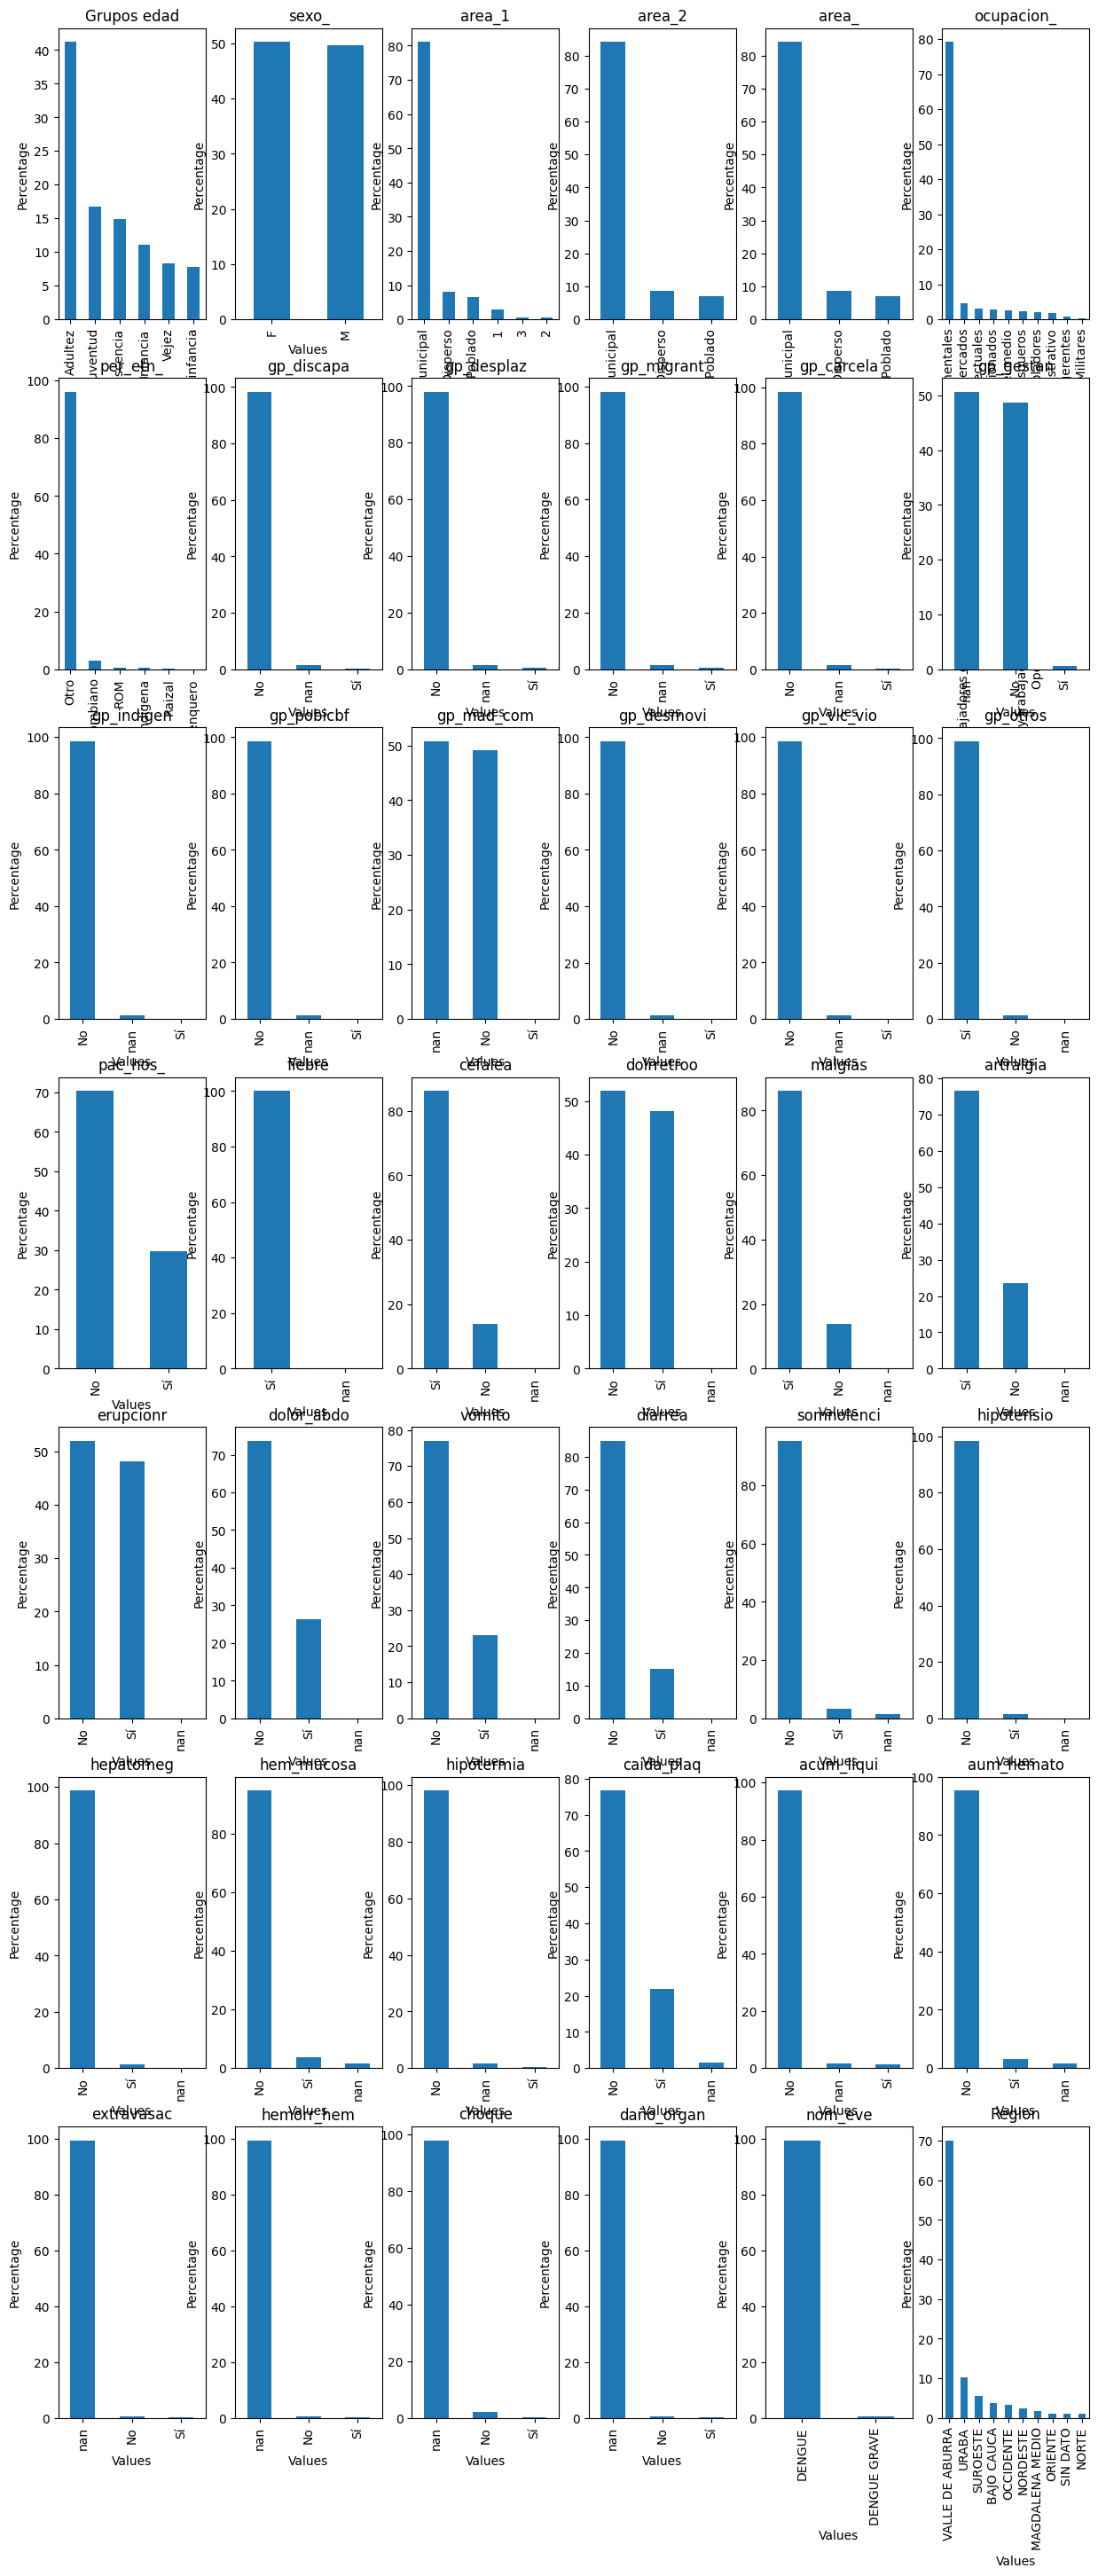

In [3]:
# Identificar columnas de tipo object
object_columns = df.select_dtypes(include=['object']).columns
print(f"Number of object columns: {len(object_columns)}")

# Calcular el número de filas y columnas para la matriz de subplots
num_cols = 6  # Número de columnas en la matriz de subplots
num_rows = (len(object_columns) + num_cols - 1) // num_cols  # Número de filas en la matriz de subplots

# Crear gráficos de porcentaje para cada columna de tipo object en una matriz de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar la iteración

for i, col in enumerate(object_columns):
    value_counts = df[col].value_counts(dropna=False)
    percentage = (value_counts / len(df)) * 100
    percentage.plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel('Values')

# Eliminar subplots vacíos
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
del axes, col, fig, num_cols, num_rows, object_columns, percentage, value_counts, i # Eliminar variables no necesarias

Se puede observar que la mayoria de variables son Categóricas. Se identifica y seleccionan las variables relevantes dentro de los 2 grupos (variables socio-demográficas y variables clínicas). 

Las siguientes columnas se eliminan bajo los siguientes criterios:
- **area_1**: Misma información de la columna area.
- **area_2**: Misma información de la columna area.
- **gp_mad_com**: No se tiene contexto sobre la columna y el 51% de los datos estan vacíos.
- **tpo_consulta(consulta-inicio)**: No se tiene contexto sobre la columna.
- **tpo_deterioro(pos-consulta)**: No se tiene contexto sobre la columna.
- **fec_hos**:En el contexto del estudio, no tiene utilidad esta columna.
- **fec_con**:En el contexto del estudio, no tiene utilidad esta columna.
- **ini_sin**:En el contexto del estudio, no tiene utilidad esta columna.
- **fiebre**: 99,98% de los datos estan marcados como SI, los demás vacíos, lo que indica que sobre todas las personas que hacen parte de la muestra tienen fiebre y al no tener variabilidad sobre esta columna no influye / impacta sobre el modelo.
- **extravasac**: El 99% de la columna viene vacia y no hay criterio claro para imputación.
- **hemorr_hem**: El 99% de la columna viene vacia y no hay criterio claro para imputación.
- **choque**: El 99% de la columna viene vacia y no hay criterio claro para imputación.
- **daño_organ**: El 99% de la columna viene vacia y no hay criterio claro para imputación.

In [4]:
# Columnas innecesarias
col_eliminar = ['area_1', 'area_2', 'gp_mad_com', 'tpo_consulta(consulta-inicio)', 'fiebre', 'extravasac', 'hemorr_hem', 'choque', 'daño_organ', 'tpo_deterioro(hosp-consul)', 'fec_hos', 'fec_con', 'ini_sin']

# Columnas de interés separadas por categorías
col_soc_demograficas = ['edad',
                        'Grupos edad',
                        'sexo',
                        'area',
                        'ocupacion',
                        'per_etn',
                        'gp_discapa',
                        'gp_desplaz',
                        'gp_migrant',
                        'gp_gestan',
                        'gp_pobicbf',
                        'gp_desmovi',
                        'gp_vic_vio',
                        'gp_otros',
                        'gp_carcela',
                        'gp_indigen',
                        'nom_eve',
                        'Region']

col_clinicas = ['edad',
                'pac_hos',
                'cefalea',
                'dolrretroo',
                'malgias','artralgia',
                'erupcionr',
                'dolor_abdo',
                'vomito',
                'diarrea',
                'somnolenci',
                'hipotensio',
                'hepatomeg',
                'hem_mucosa',
                'hipotermia',
                'caida_plaq',
                'acum_liqui',
                'aum_hemato',
                'nom_eve']

# Alistamiento del Dataset
df.rename(columns=lambda x: x.rstrip('_'), inplace=True)
df.drop(inplace=True,columns=col_eliminar) # Eliminar columnas innecesarias

# Imputación de valores faltantes
df.loc[(df['sexo'] == 'M') & (df['gp_gestan'].isnull()), 'gp_gestan'] = 'No'        # Se reemplazan los valores nulos de gp_gestan por 'No' si el sexo es Masculino

### **Parte A - Predecir Dengue o Dengue Grave a partir de Variables Socio-demográficas**

#### **Depuración del Dataframe**
Inicialmente, se depuran las columnas de interés y se eliminan registros vacíos para el estudio 

In [5]:
df1 = df.copy() # Crear una copia del DataFrame original
df1 = df1[col_soc_demograficas] # Dejar las columnas de interés
print(f'Registros del Dataframe Original: {df1.shape[0]}')

# Eliminar registros con datos nulos
df1.dropna(inplace=True)
print(f'Registros del Dataframe Eliminando nulos en columnas de interés: {df1.shape[0]}')


Registros del Dataframe Original: 50397
Registros del Dataframe Eliminando nulos en columnas de interés: 49475


Luego, procedemos a Dummificar las columnas categoricas mediante los procedimientos de label encoder y one hot encoder

#### **Dummificación de variables categoricas (binarias, ordinales y nominales)**


In [6]:
col_binarias = ['sexo', 'gp_discapa', 'gp_desplaz', 'gp_migrant', 'gp_carcela', 'gp_gestan', 'gp_indigen', 'gp_pobicbf', 'gp_desmovi', 'gp_vic_vio', 'gp_otros','nom_eve']
col_ordinales = ['Grupos edad']	
col_nominales = ['area', 'ocupacion', 'per_etn', 'Region']

print(f'Dimensionalidad del Dataframe ANTES de aplicar label / One hot encoding: {df1.shape}')
# Label Encoding para columnas binarias
le = LabelEncoder()
for col in col_binarias:
    df1[col] = le.fit_transform(df1[col])

# Label Encoding para Grupos Edad
orden = ['Primera infancia', 'Infancia', 'Adolescencia', 'Juventud', 'Adultez', 'Vejez']
le_ordinal = LabelEncoder()
le_ordinal.fit(orden)
df1['Grupos edad'] = le_ordinal.transform(df1['Grupos edad'])

df1 = pd.get_dummies(df1, columns=col_nominales, dtype=int)
del le, le_ordinal, col_binarias, col_nominales, col_ordinales, orden, col # Eliminar variables no necesarias
print(f'Dimensionalidad del Dataframe DESPUÉS de aplicar label / One hot encoding: {df1.shape}')

Dimensionalidad del Dataframe ANTES de aplicar label / One hot encoding: (49475, 18)
Dimensionalidad del Dataframe DESPUÉS de aplicar label / One hot encoding: (49475, 43)


#### **Dataset de Prueba y de entrenamiento**

Una vez se haya dummificado las columnas, procedemos a separar los datos de entrenamiento y prueba mediante un Hold-Out

In [7]:
# Dividir el dataset en entrenamiento y prueba

X = df1.drop(columns=['nom_eve'])
y = df1['nom_eve']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
# Ajustar y transformar los datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Como necesitamos llamar a los modelos de regresión logistica y evaluarlos múltiples veces, tomamos la estrategia de crear 4 clases para cada uno de los modelos y establecer dentro de las clases unas métricas de evaluación y la generación de la matriz de confusión, estas clases se llaman al inicio del Script y se pueden ver en el archivo [functions.py](functions/functions.py), al inicio se observa de la siguiente manera:
```python
from functions.functions import RegresionLogistica, RegresionLogisticaLasso, RegresionLogisticaRidge, RegresionElasticNet
```

#### **Regresión Logística**

Accuracy: 1.00
Kappa: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9848
           1       0.00      0.00      0.00        47

    accuracy                           1.00      9895
   macro avg       0.50      0.50      0.50      9895
weighted avg       0.99      1.00      0.99      9895



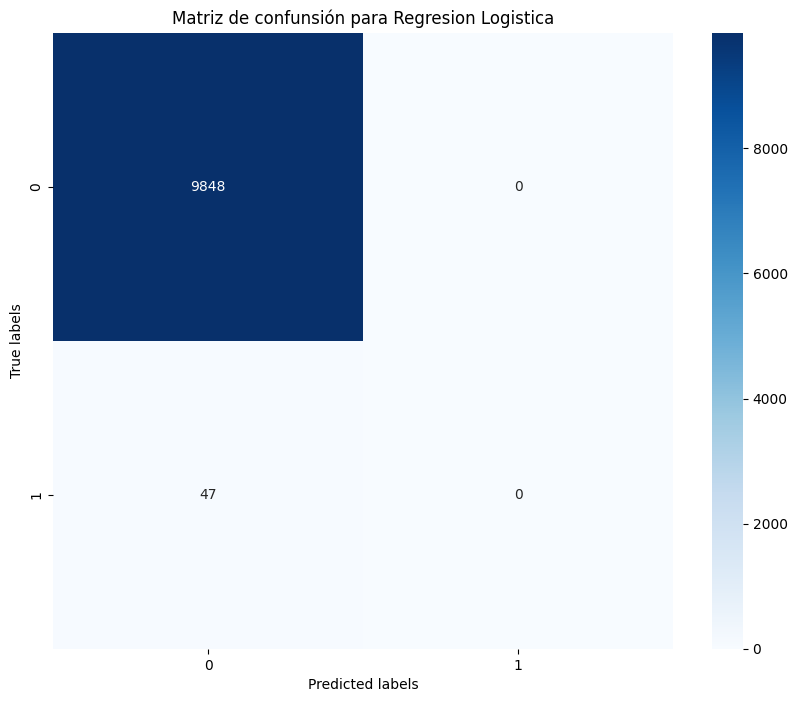

In [8]:
# Instanciar el Objeto RegresionLogistica
rl = RegresionLogistica()
rl.fit_model(X_train_scaled, y_train)
y_pred_rl = rl.predict(X_test_scaled)
accuracy_rl = accuracy_score(y_test, y_pred_rl)
rl.evaluate(y_test, y_pred_rl)                     # Evaluar el modelo
rl.plot_confusion_matrix(y_test, y_pred_rl)        # Matriz de confusión

Los resultados obtenidos muestran una alta exactitud (Accuracy) del modelo, pero un valor de Kappa muy bajo. Lo que se puede interpretar de la siguiente manera:

1. **Exactitud del Modelo**:
    - La exactitud del modelo es del 100%, lo que indica que el modelo clasifica correctamente la mayoría de los casos. Sin embargo, esto es engañoso debido al desbalance de clases en el conjunto de datos que se puede llegar a dar con la variable objetivo 'NOM_EVE'.

2. **Cohen's Kappa**:
    - El valor de Kappa es 0.00, lo que indica que el modelo no tiene mejor desempeño que una clasificación aleatoria. Por lo que el modelo no está manejando adecuadamente el desbalance de clases.

3. **Desempeño en Clases Minoritarias**:
    - La clase minoritaria (1) tiene una precisión, recall y f1-score de 0.00, lo que indica que el modelo no está prediciendo correctamente ningún caso de la clase minoritaria.

4. **Macro y Weighted Averages**:
    - Los promedios macro y ponderados muestran que, aunque el modelo tiene un buen desempeño en la clase mayoritaria, su desempeño general es pobre debido a la incapacidad de predecir la clase minoritaria.

Aunque el modelo tiene una alta exactitud, su incapacidad para manejar el desbalance de clases y predecir correctamente la clase minoritaria lo hace inadecuado para este problema.

#### **Regresión Logística - Ridge**

Accuracy: 1.00
Kappa: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9848
           1       0.00      0.00      0.00        47

    accuracy                           1.00      9895
   macro avg       0.50      0.50      0.50      9895
weighted avg       0.99      1.00      0.99      9895



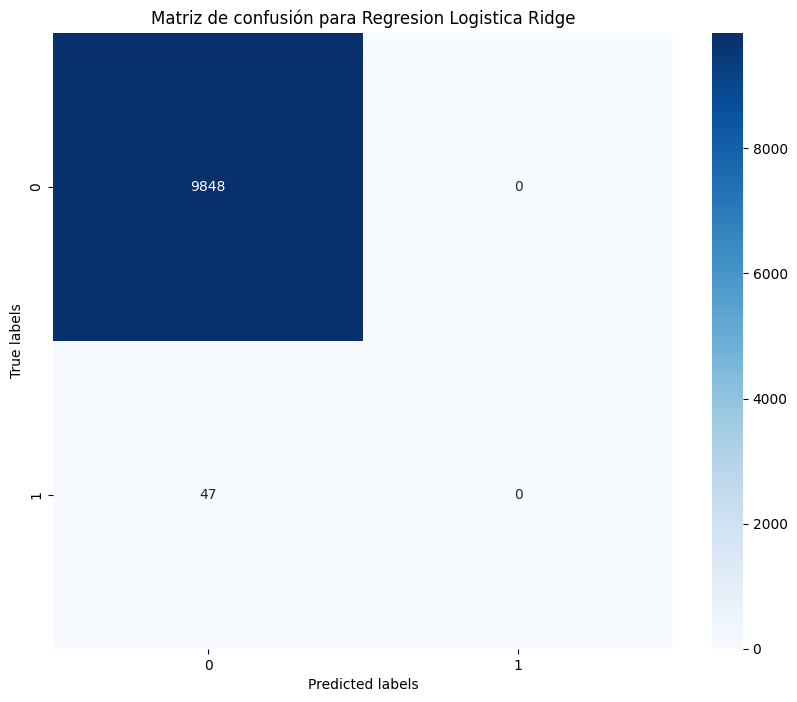

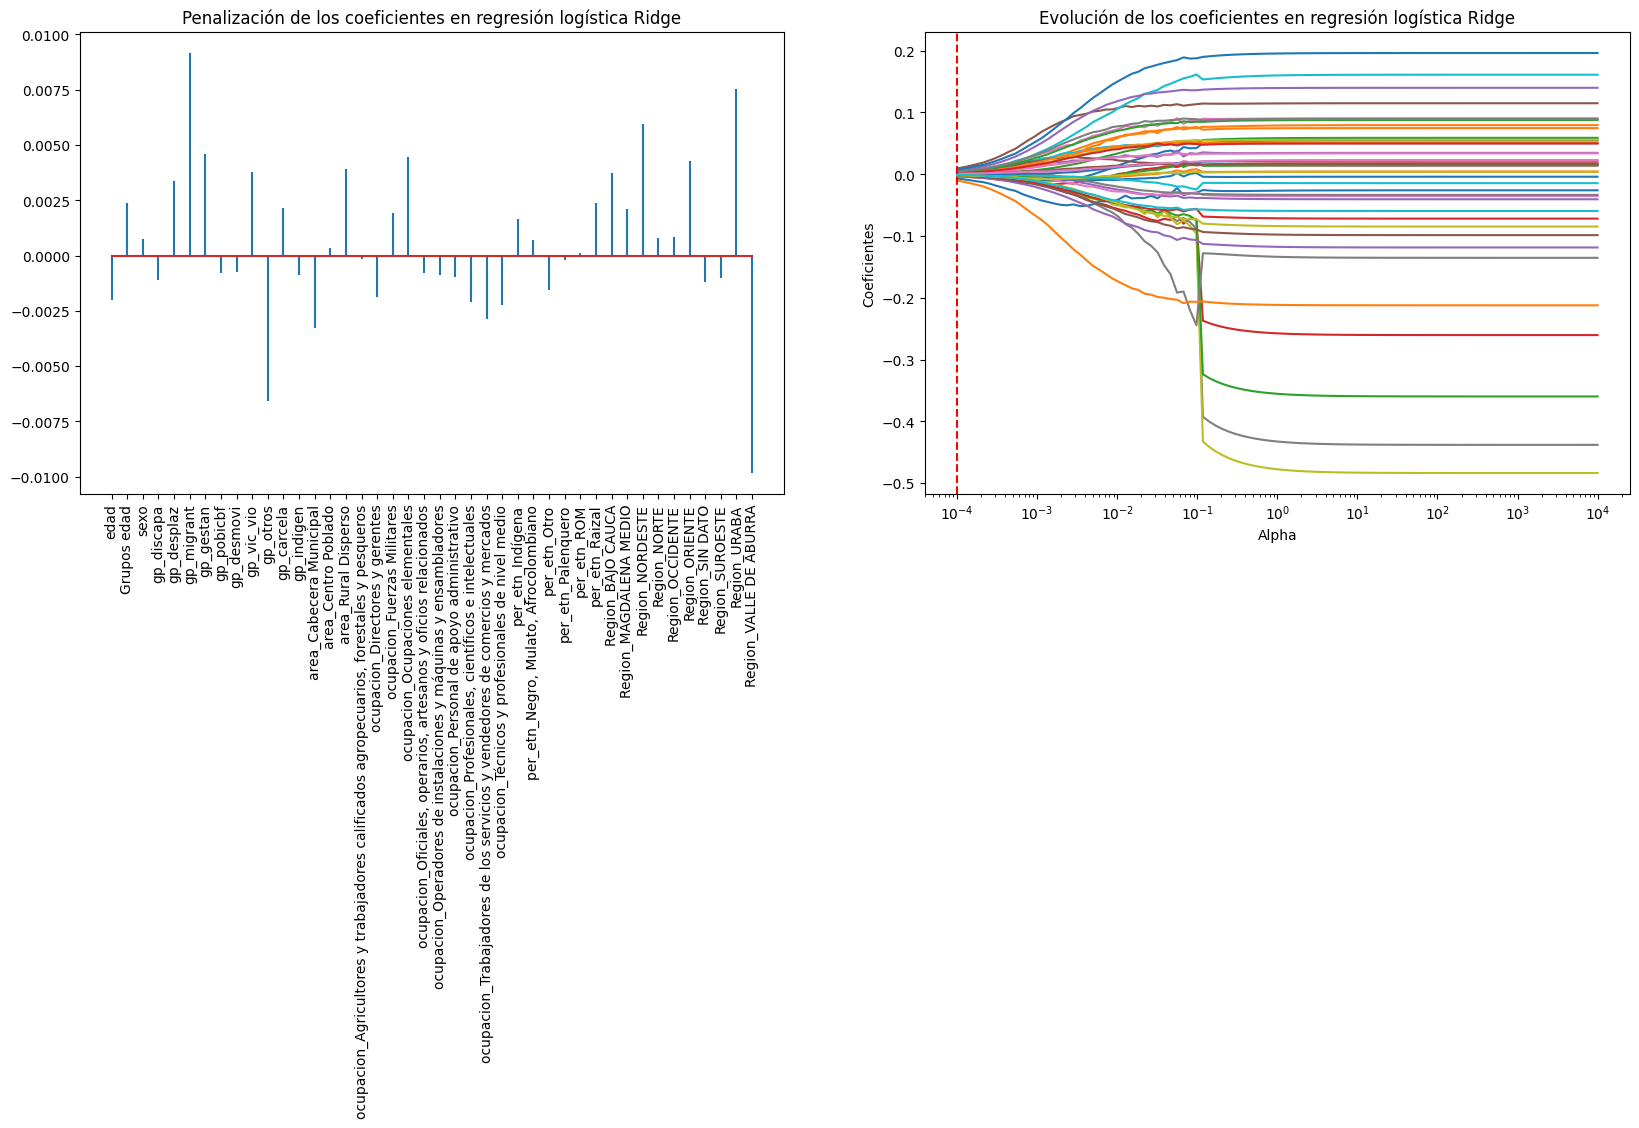

In [9]:
# Instanciar el Objeto RegresionLogistica Ridge
cs = np.logspace(-4, 4, 100)                            # Definir los valores de alpha
rl2 = RegresionLogisticaRidge(Cs = cs)
rl2.fit_model(X_train_scaled, y_train)
y_pred_ridge = rl2.predict(X_test_scaled)
rl2.evaluate(y_test, y_pred_ridge)                     # Evaluar el modelo
rl2.plot_confusion_matrix(y_test, y_pred_ridge)        # Matriz de confusión
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)

# Obtener los coeficientes para cada valor de alpha
ridge_coefs = []
for a in cs:
    ridge = LogisticRegression(penalty='l2', C=a, solver='lbfgs', random_state=42)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_.flatten())  # Aplanar los coeficientes y agregarlos a la lista

ridge_coefs = np.array(ridge_coefs)  # Convertir la lista en un arreglo de numpy bidimensional (100, n_coeficientes)

# Coeficientes del modelo Ridge con el alpha óptimo y los predictores seleccionados
df_coeficientes_Ridge = pd.DataFrame({
    "predictores": X_train.columns,
    "coeficientes": rl2.coefs().flatten()
    })

df_coeficientes_Ridge = df_coeficientes_Ridge.query("coeficientes != 0")
#print(df_coeficientes_Ridge)

# Generar las gráficas para la evolución de los coeficientes de regresión
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Gráfica para penalización de Coeficientes
axes[0].stem(df_coeficientes_Ridge.predictores, df_coeficientes_Ridge.coeficientes, markerfmt = ' ')
axes[0].set_xticks(df_coeficientes_Ridge.predictores)
axes[0].set_xticklabels(df_coeficientes_Ridge.predictores, rotation = 90)
axes[0].set_title('Penalización de los coeficientes en regresión logística Ridge')
# Gráfica para coeficientes vs Alpha
axes[1].plot(cs, ridge_coefs)
axes[1].axvline(rl2.model.C_, color='red', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coeficientes')
axes[1].set_title('Evolución de los coeficientes en regresión logística Ridge')
axes[1].axis('tight')

plt.tight_layout()
plt.show()

A pesar de que se regularizan las variables dependientes para hacer mas simple el modelo, Los resultados son los mismos al **modelo de Regresión Logística Simple** ejecutado anteriormente, por lo que se concluye que: 

Aunque el modelo tiene una alta exactitud, su incapacidad para manejar el desbalance de clases y predecir correctamente la clase minoritaria lo hace inadecuado para este problema.

#### **Regresión Logística - Lasso**

Accuracy: 1.00
Kappa: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9848
           1       0.00      0.00      0.00        47

    accuracy                           1.00      9895
   macro avg       0.50      0.50      0.50      9895
weighted avg       0.99      1.00      0.99      9895



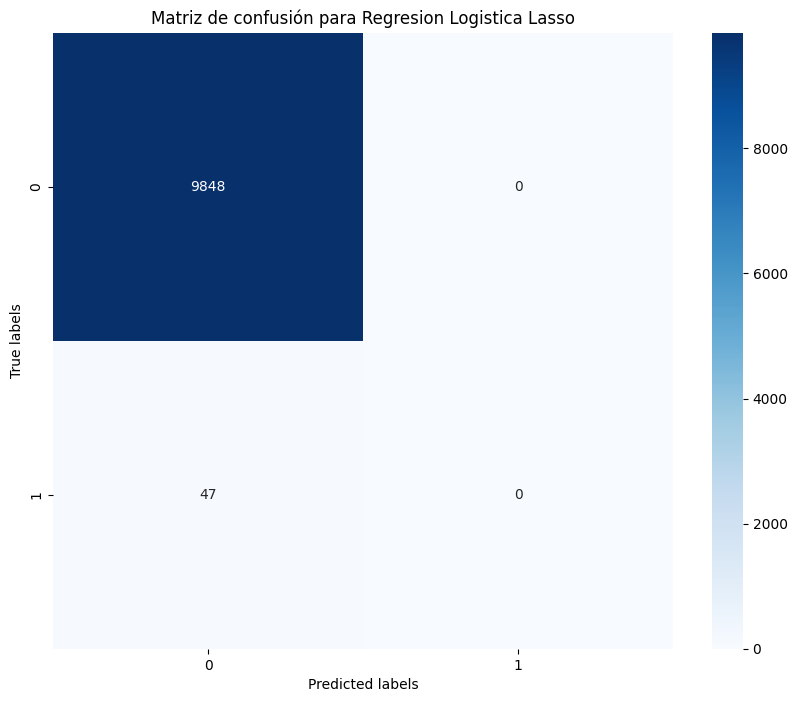

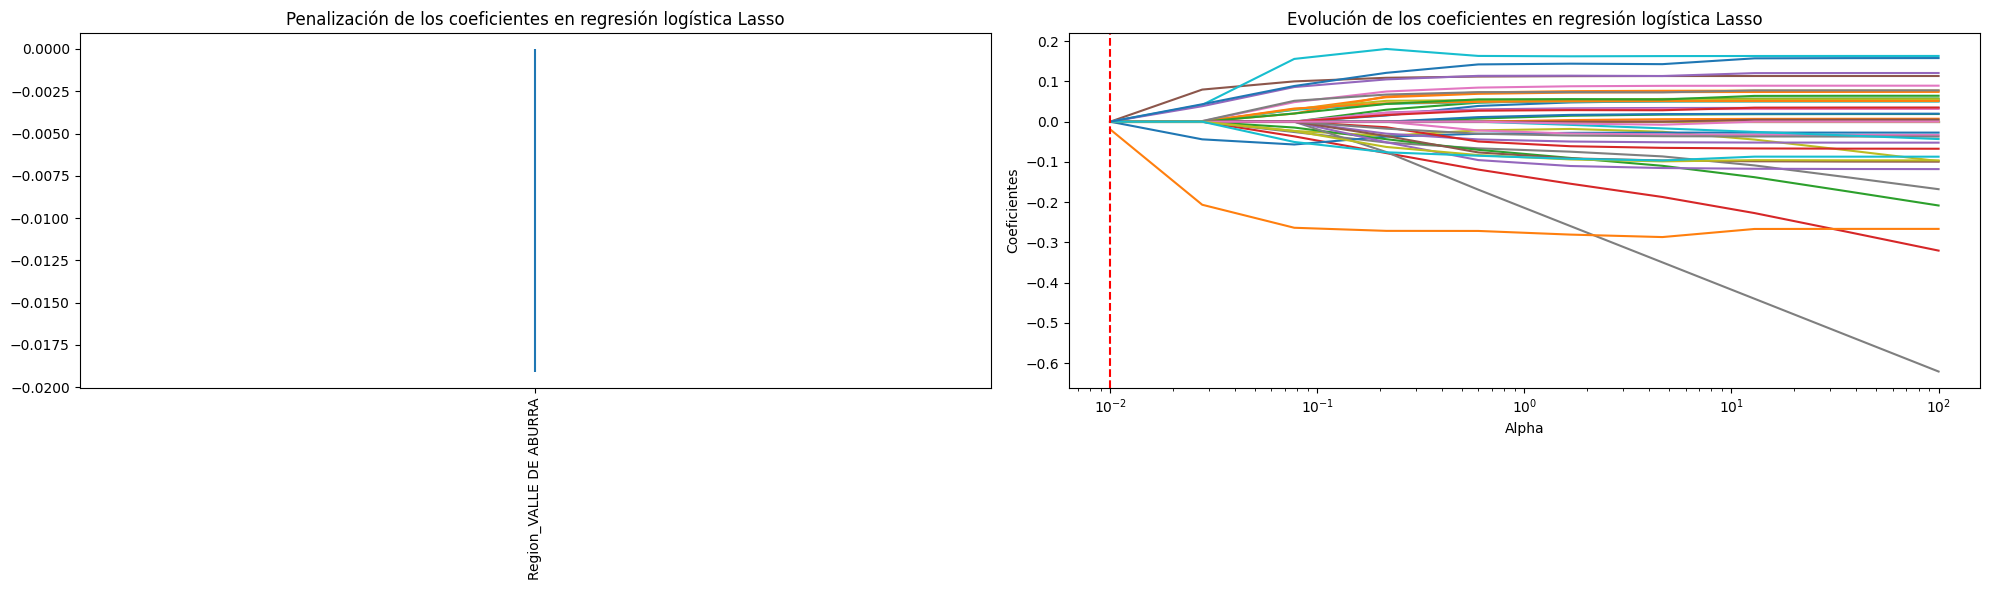

In [10]:
# Instanciar el Objeto RegresionLogistica Lasso
cs = np.logspace(-2, 2, 10)                            # Definir los valores de alpha, se ponen 10 valores por la limitacion computacional
rl1 = RegresionLogisticaLasso(Cs = cs)
rl1.fit_model(X_train_scaled, y_train)
y_pred_lasso = rl1.predict(X_test_scaled)
rl1.evaluate(y_test, y_pred_lasso)                     # Evaluar el modelo
rl1.plot_confusion_matrix(y_test, y_pred_lasso)        # Matriz de confusión
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)

# Obtener los coeficientes para cada valor de alpha
lasso_coefs = []
for a in cs:
    lasso = LogisticRegression(penalty='l1', C=a, solver='liblinear', random_state=42)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_.flatten())  # Aplanar los coeficientes y agregarlos a la lista

lasso_coefs = np.array(lasso_coefs)  # Convertir la lista en un arreglo de numpy bidimensional (100, n_coeficientes)

# Coeficientes del modelo Lasso con el alpha óptimo y los predictores seleccionados
df_coeficientes_Lasso = pd.DataFrame({
    "predictores": X_train.columns,
    "coeficientes": rl1.coefs().flatten()
    })

df_coeficientes_Lasso = df_coeficientes_Lasso.query("coeficientes != 0")
#print(df_coeficientes_Lasso)

# Generar las gráficas para la evolución de los coeficientes de regresión
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Gráfica para penalización de Coeficientes
axes[0].stem(df_coeficientes_Lasso.predictores, df_coeficientes_Lasso.coeficientes, markerfmt = ' ')
axes[0].set_xticks(df_coeficientes_Lasso.predictores)
axes[0].set_xticklabels(df_coeficientes_Lasso.predictores, rotation = 90)
axes[0].set_title('Penalización de los coeficientes en regresión logística Lasso')
# Gráfica para coeficientes vs Alpha
axes[1].plot(cs, lasso_coefs)
axes[1].axvline(rl1.model.C_, color='red', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coeficientes')
axes[1].set_title('Evolución de los coeficientes en regresión logística Lasso')
axes[1].axis('tight')

plt.tight_layout()
plt.show()

**En Lasso**, podemos ver que la regularización es mas fuerte al tal punto de que solo queda una variable dependiente con un valor para su coeficiente diferente de 0, sin embargo, en cuanto a los resultados vistos desde la matriz de confusión, Los resultados son los mismos a los **2 modelos anteriores** ejecutado anteriormente, por lo que se concluye que Lasso tampoco es capaz de manejar el desbalance de clases y predecir correctamente la clase minoritaria, lo hace inadecuado para este problema.

#### **Regresión Logística - Elastic Net**

Accuracy: 1.00
Kappa: 0.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9848
           1       0.00      0.00      0.00        47

    accuracy                           1.00      9895
   macro avg       0.50      0.50      0.50      9895
weighted avg       0.99      1.00      0.99      9895



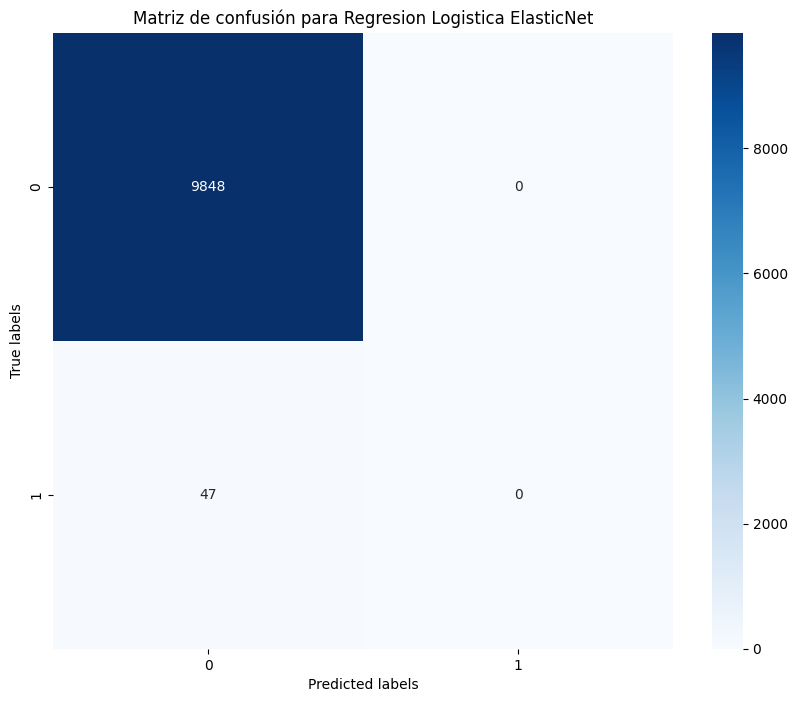

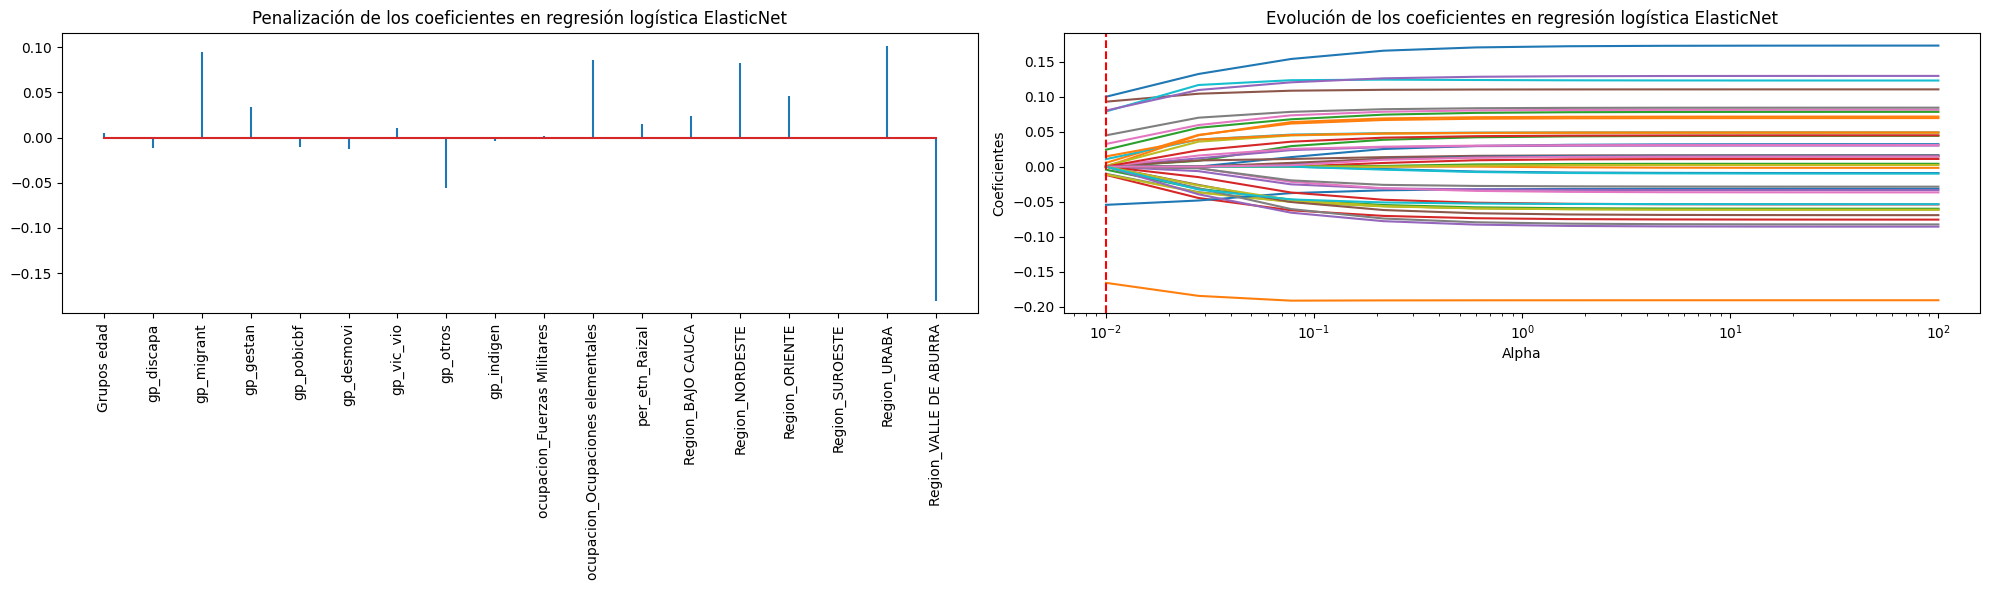

In [11]:
# Instanciar el Objeto RegresionLogistica ElasticNet

l1_ratios_vector=[0.2, 0.4, 0.6, 0.8, 1]                                # Definir los valores de l1, se ponen 5 valores por la limitacion computacional
cs = np.logspace(-2, 2, 10)                                             # Definir los valores de alpha, se ponen 10 valores por la limitacion computacional
rle = RegresionElasticNet(Cs = cs, l1_ratios=l1_ratios_vector)
rle.fit_model(X_train_scaled, y_train)
y_pred_enet = rle.predict(X_test_scaled)
rle.evaluate(y_test, y_pred_enet)                                      # Evaluar el modelo
rle.plot_confusion_matrix(y_test, y_pred_enet)                         # Matriz de confusión
accuracy_enet = accuracy_score(y_test, y_pred_enet)

# Obtener los coeficientes para cada valor de alpha con el l1_ratio óptimo
enet_coefs = []
for a in cs:
    enet = LogisticRegression(penalty='elasticnet', C=a, solver='saga', l1_ratio=rle.model.l1_ratio_[0], random_state=42)
    enet.fit(X_train_scaled, y_train)
    enet_coefs.append(enet.coef_.flatten())  # Aplanar los coeficientes y agregarlos a la lista

enet_coefs = np.array(enet_coefs)  # Convertir la lista en un arreglo de numpy bidimensional (100, n_coeficientes)

# Coeficientes del modelo Lasso con el alpha óptimo y los predictores seleccionados
df_coeficientes_Enet = pd.DataFrame({
    "predictores": X_train.columns,
    "coeficientes": rle.model.coef_.flatten()
    })

df_coeficientes_Enet = df_coeficientes_Enet.query("coeficientes != 0")
#print(df_coeficientes_Lasso)

# Generar las gráficas para la evolución de los coeficientes de regresión
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Gráfica para penalización de Coeficientes
axes[0].stem(df_coeficientes_Enet.predictores, df_coeficientes_Enet.coeficientes, markerfmt = ' ')
axes[0].set_xticks(df_coeficientes_Enet.predictores)
axes[0].set_xticklabels(df_coeficientes_Enet.predictores, rotation = 90)
axes[0].set_title('Penalización de los coeficientes en regresión logística ElasticNet')
# Gráfica para coeficientes vs Alpha
axes[1].plot(cs, enet_coefs)
axes[1].axvline(rle.model.C_, color='red', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coeficientes')
axes[1].set_title('Evolución de los coeficientes en regresión logística ElasticNet')
axes[1].axis('tight')

plt.tight_layout()
plt.show()

**En ElasticNet**, El resultado encontrado (_también esperado_) es el mismo a los 3 modelos anteriores, ya que ni Lasso ni Ridge mostraron unos resultados diferentes, el modelo ElasticNet no es el adecuado para predecir este modelo por el desbalanceo de las clases 

### **Comparación de Modelos**

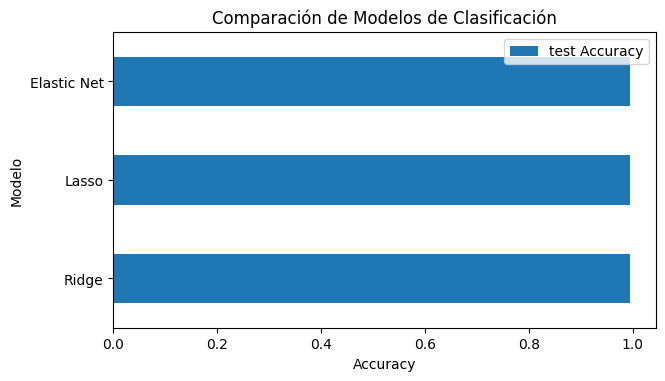

Accuracy para cada modelo:
        modelo  test Accuracy
0        Ridge        0.99525
1        Lasso        0.99525
2  Elastic Net        0.99525


In [12]:
# Comparación de modelos
df_comparacion = pd.DataFrame({
    'modelo': ['Ridge', 'Lasso', 'Elastic Net'],
    'test Accuracy': [accuracy_ridge, accuracy_lasso, accuracy_enet]
})

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Modelo')
ax.set_title('Comparación de Modelos de Clasificación')
plt.show()

# Mostrar Accuracy de cada modelo
print("Accuracy para cada modelo:")
print(df_comparacion)

Los resultados obtenidos muestran una alta exactitud (Accuracy) para todos los modelos de regresión logística evaluados (Ridge, Lasso y Elastic Net), con un valor de 0.99525. Sin embargo, esta alta exactitud es engañosa debido al desbalanceo de valores en la variable respuesta 'NOM_EVE'. 

El desbalanceo de clases significa que la mayoría de los registros pertenecen a una sola clase, que en este caso es 'DENGUE'. Lo que lleva a que los modelos predigan predominantemente esa clase mayoritaria, resultando en una alta exactitud pero un pobre desempeño en la clase minoritaria. Esto se refleja en la incapacidad de los modelos para manejar adecuadamente el desbalance de clases y predecir correctamente la clase minoritaria.

Por lo tanto, aunque los modelos muestran una alta exactitud, su desempeño general es inadecuado para este problema debido al desbalanceo de la variable respuesta 'NOM_EVE'. Por ende se procede a cambiar la estrategia y a utilizar técnicas de remuestreo para abordar el desbalance de clases y mejorar el desempeño de los modelos.

#### **Balanceo de Dataframe para Entrenar el modelo**
Una vez aplicada la Dummyficación de variables, se procede a analizar la variable objetivo "NOM_EVE"

In [13]:
df1['nom_eve'].value_counts()

nom_eve
0    49205
1      270
Name: count, dtype: int64

Se puede observar que el Dataset en la variable objetivo se encuentra enormemente desbalanceado, y no significa que esté mal, es el comportamiento natural del fenomeno estudiado, sin embargo, para usos prácticos y mejores resultados del modelo, se opta por balancear el conjunto de datos de Entrenamiento de la siguiente forma:

- **Conjunto de datos de Entrenamiento:**
    - Registros con variable Objetivo 0 (Dengue): 216
    - Registros con variable Objetivo 1 (Dengue Grave): 216 (80% de registros con este valor)

- **Conjunto de datos de Pruebas:**
    - Registros con variable Objetivo 0 (Dengue): 48.989
    - Registros con variable Objetivo 1 (Dengue Grave): 54 (20% de registros con este valor)


In [14]:
# Dividir los datos en entrenamiento y prueba

# Seleccionar los primeros 216 registros con 'nom_eve' = 0 y 'nom_eve' = 1 

dengue_train = df1[df1['nom_eve'] == 0].sample(n=216, random_state=42)
dengue_grave_train = df1[df1['nom_eve'] == 1].sample(n=216, random_state=42)
train_data = pd.concat([dengue_train, dengue_grave_train])

# Definir X_train y y_train
X_train = train_data.drop(columns=['nom_eve'])
y_train = train_data['nom_eve']

# Calcular Test Data
test_data = df1.drop(train_data.index)
X_test = test_data.drop(columns=['nom_eve'])
y_test = test_data['nom_eve']

# Verificación de balance en el conjunto de entrenamiento y prueba
print("Distribución en el conjunto de entrenamiento:")
print(y_train.value_counts())
print("\nDistribución en el conjunto de prueba:")
print(y_test.value_counts())

del dengue_train, dengue_grave_train, train_data, test_data # Eliminar variables no necesarias

Distribución en el conjunto de entrenamiento:
nom_eve
0    216
1    216
Name: count, dtype: int64

Distribución en el conjunto de prueba:
nom_eve
0    48989
1       54
Name: count, dtype: int64


De igual manera que con el dataset de train desbalanceado, se procede a realizar la estandarizacion de los datos y a ejecutar los modelos de regresión.

In [15]:
# Ajustar y transformar los datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### **Regresión Logística**

Accuracy: 0.69
Kappa: 0.00
              precision    recall  f1-score   support

           0       1.00      0.69      0.82     48989
           1       0.00      0.57      0.00        54

    accuracy                           0.69     49043
   macro avg       0.50      0.63      0.41     49043
weighted avg       1.00      0.69      0.82     49043



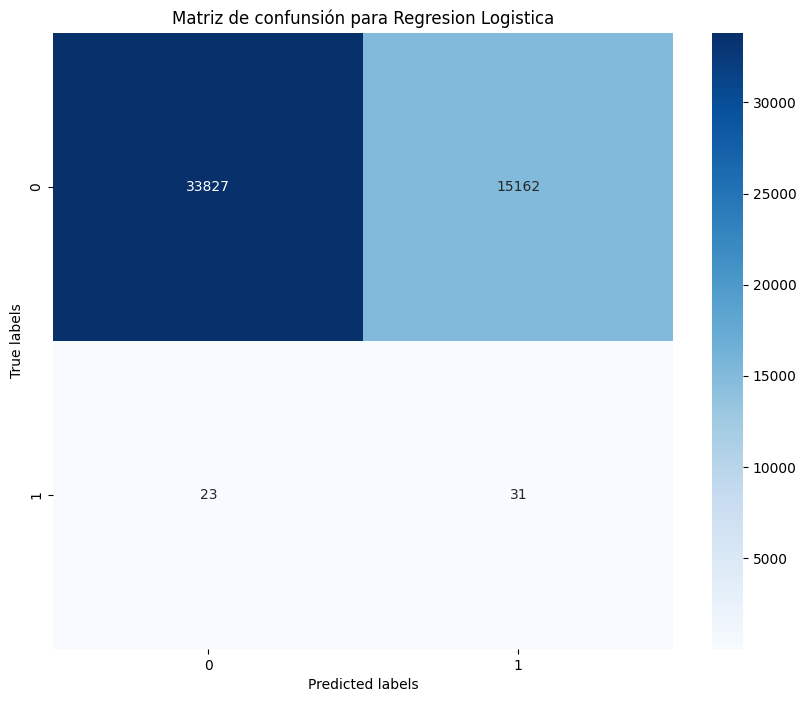

In [16]:
# Instanciar el Objeto RegresionLogistica
rl = RegresionLogistica()
rl.fit_model(X_train_scaled, y_train)
y_pred_rl = rl.predict(X_test_scaled)
rl.evaluate(y_test, y_pred_rl)                     # Evaluar el modelo
rl.plot_confusion_matrix(y_test, y_pred_rl)        # Matriz de confusión
accuracy_rl = accuracy_score(y_test, y_pred_rl)

De los resultados anteriores, se puede ver que la exactitud del modelo es del 69%, lo que indica que el modelo clasifica correctamente la mayoría de los casos. Sin embargo, esto es engañoso debido a que mas adelante se ve que el Kappa es 0, no hay un buen desempeño para la clase minoritaria.

#### **Regresión Logística - Ridge**

Accuracy: 0.68
Kappa: 0.00
              precision    recall  f1-score   support

           0       1.00      0.68      0.81     48989
           1       0.00      0.61      0.00        54

    accuracy                           0.68     49043
   macro avg       0.50      0.65      0.41     49043
weighted avg       1.00      0.68      0.81     49043



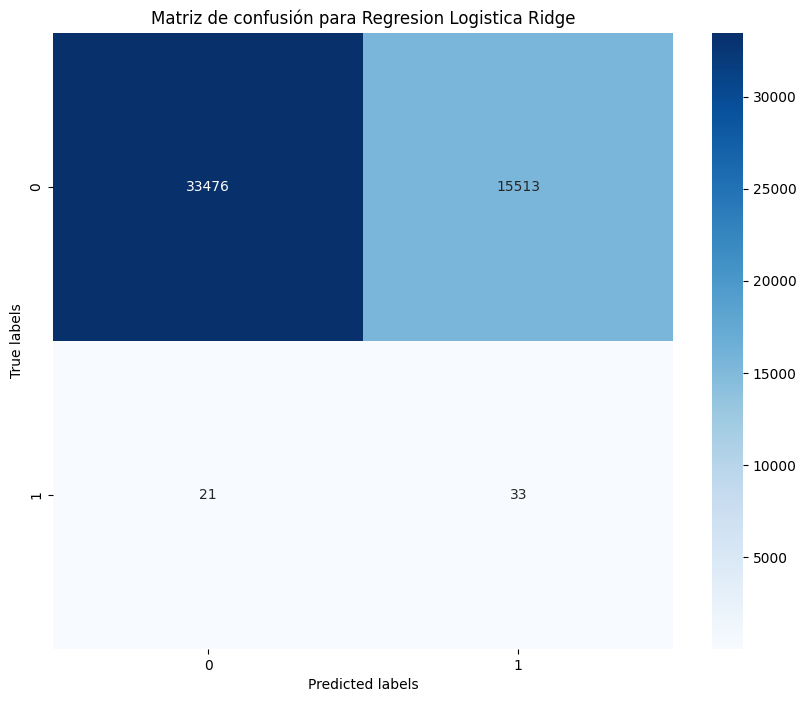

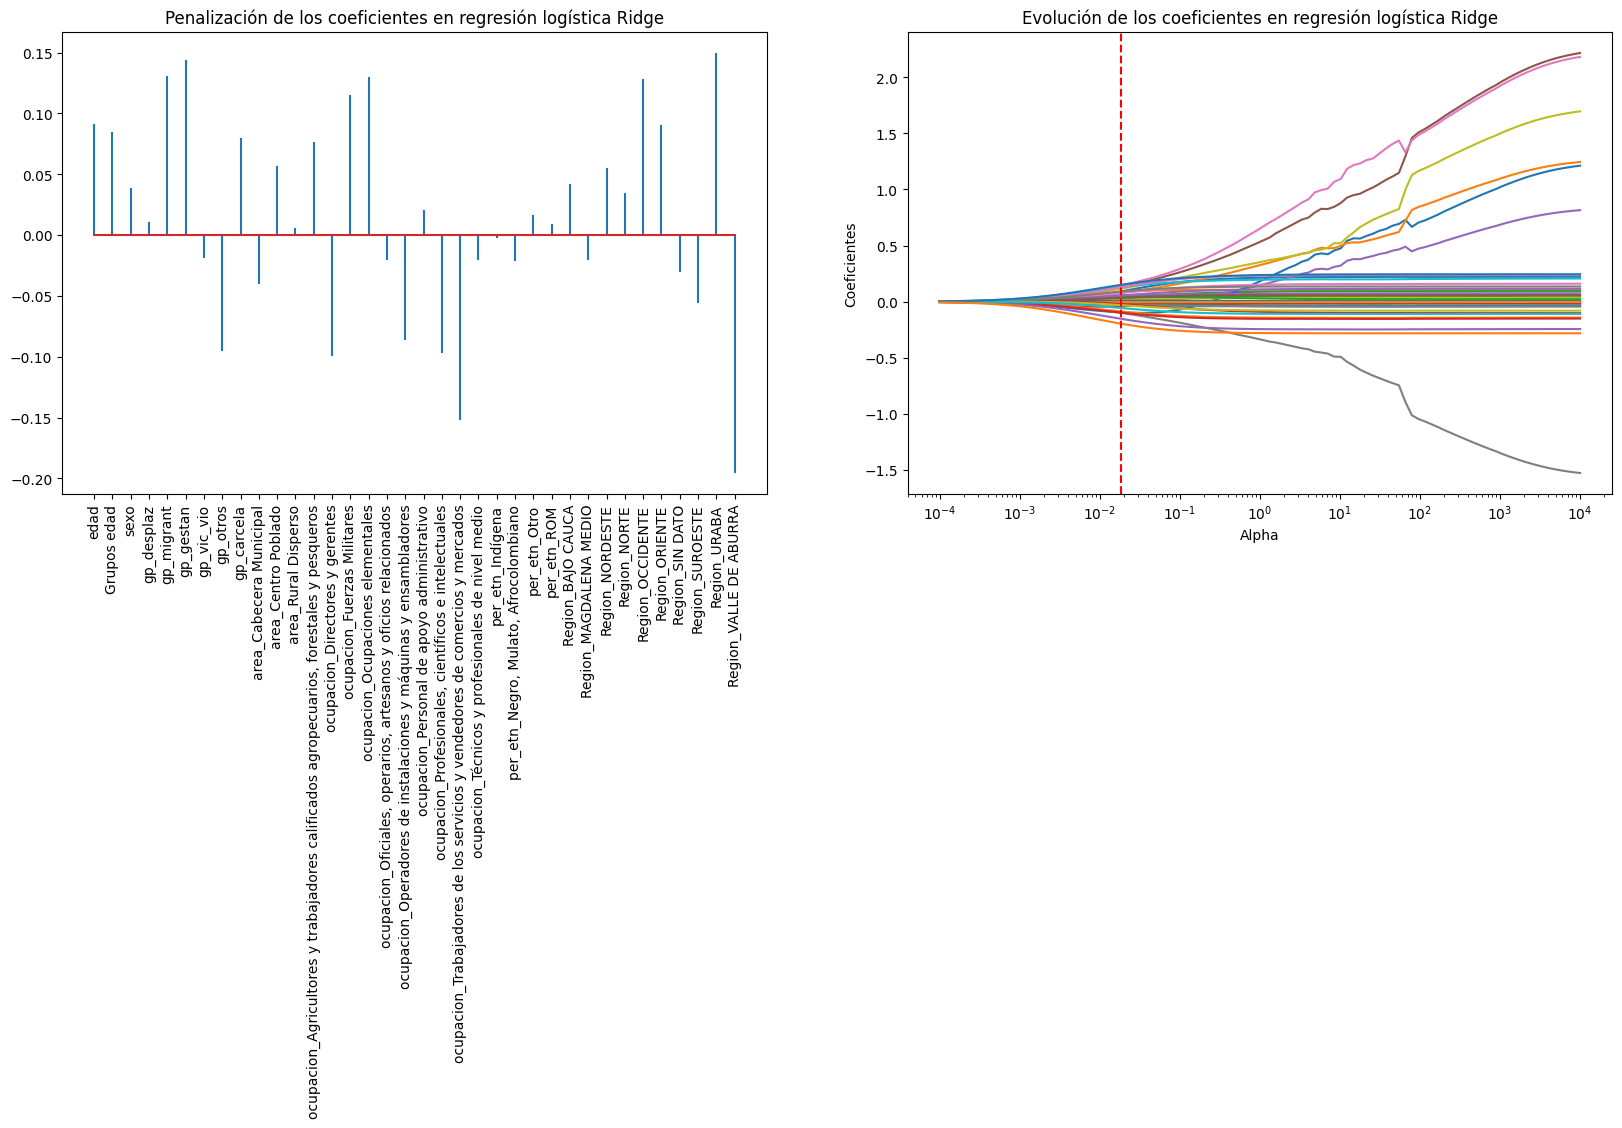

In [17]:
# Instanciar el Objeto RegresionLogistica Ridge
cs = np.logspace(-4, 4, 100)                            # Definir los valores de alpha
rl2 = RegresionLogisticaRidge(Cs = cs)
rl2.fit_model(X_train_scaled, y_train)
y_pred_ridge = rl2.predict(X_test_scaled)
rl2.evaluate(y_test, y_pred_ridge)                     # Evaluar el modelo
rl2.plot_confusion_matrix(y_test, y_pred_ridge)        # Matriz de confusión
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)

# Obtener los coeficientes para cada valor de alpha
ridge_coefs = []
for a in cs:
    ridge = LogisticRegression(penalty='l2', C=a, solver='lbfgs', random_state=42)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_.flatten())  # Aplanar los coeficientes y agregarlos a la lista

ridge_coefs = np.array(ridge_coefs)  # Convertir la lista en un arreglo de numpy bidimensional (100, n_coeficientes)

# Coeficientes del modelo Ridge con el alpha óptimo y los predictores seleccionados
df_coeficientes_Ridge = pd.DataFrame({
    "predictores": X_train.columns,
    "coeficientes": rl2.coefs().flatten()
    })

df_coeficientes_Ridge = df_coeficientes_Ridge.query("coeficientes != 0")
#print(df_coeficientes_Ridge)

# Generar las gráficas para la evolución de los coeficientes de regresión
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Gráfica para penalización de Coeficientes
axes[0].stem(df_coeficientes_Ridge.predictores, df_coeficientes_Ridge.coeficientes, markerfmt = ' ')
axes[0].set_xticks(df_coeficientes_Ridge.predictores)
axes[0].set_xticklabels(df_coeficientes_Ridge.predictores, rotation = 90)
axes[0].set_title('Penalización de los coeficientes en regresión logística Ridge')
# Gráfica para coeficientes vs Alpha
axes[1].plot(cs, ridge_coefs)
axes[1].axvline(rl2.model.C_, color='red', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coeficientes')
axes[1].set_title('Evolución de los coeficientes en regresión logística Ridge')
axes[1].axis('tight')

plt.tight_layout()
plt.show()

De los resultados anteriores, se puede ver que a pesar de que se busca regularizar variables, el alpha optimo no penaliza completamente alguna variable dependiente, y adicional la exactitud del modelo vs el modelo anterior baja un poco, adicional, el f1-score para la clase minoritaria es 0, por lo que se concluye que el modelo no predice correctamente la clase minoritaria.

#### **Regresión Logística - Lasso**

Accuracy: 0.70
Kappa: 0.00
              precision    recall  f1-score   support

           0       1.00      0.70      0.83     48989
           1       0.00      0.59      0.00        54

    accuracy                           0.70     49043
   macro avg       0.50      0.65      0.42     49043
weighted avg       1.00      0.70      0.83     49043



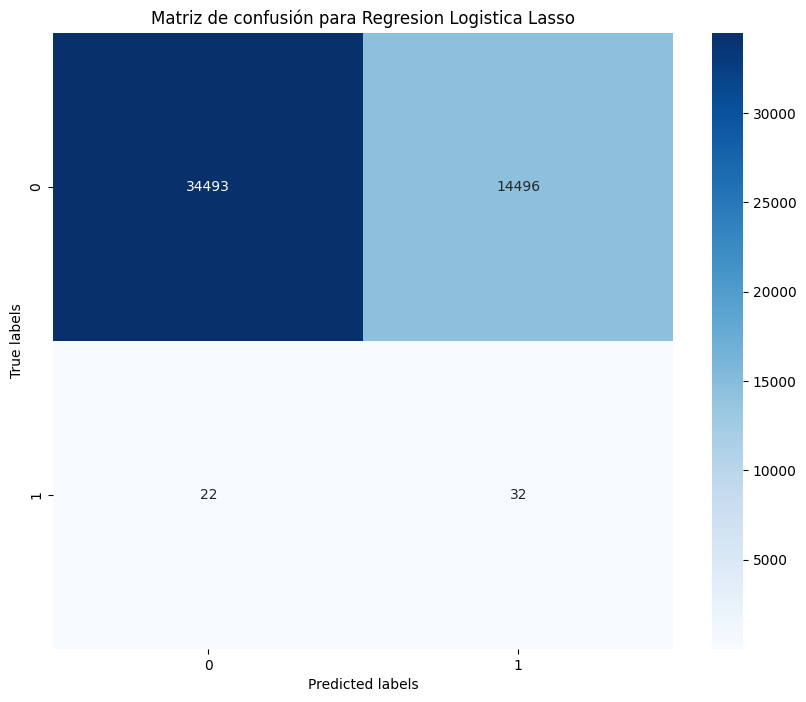

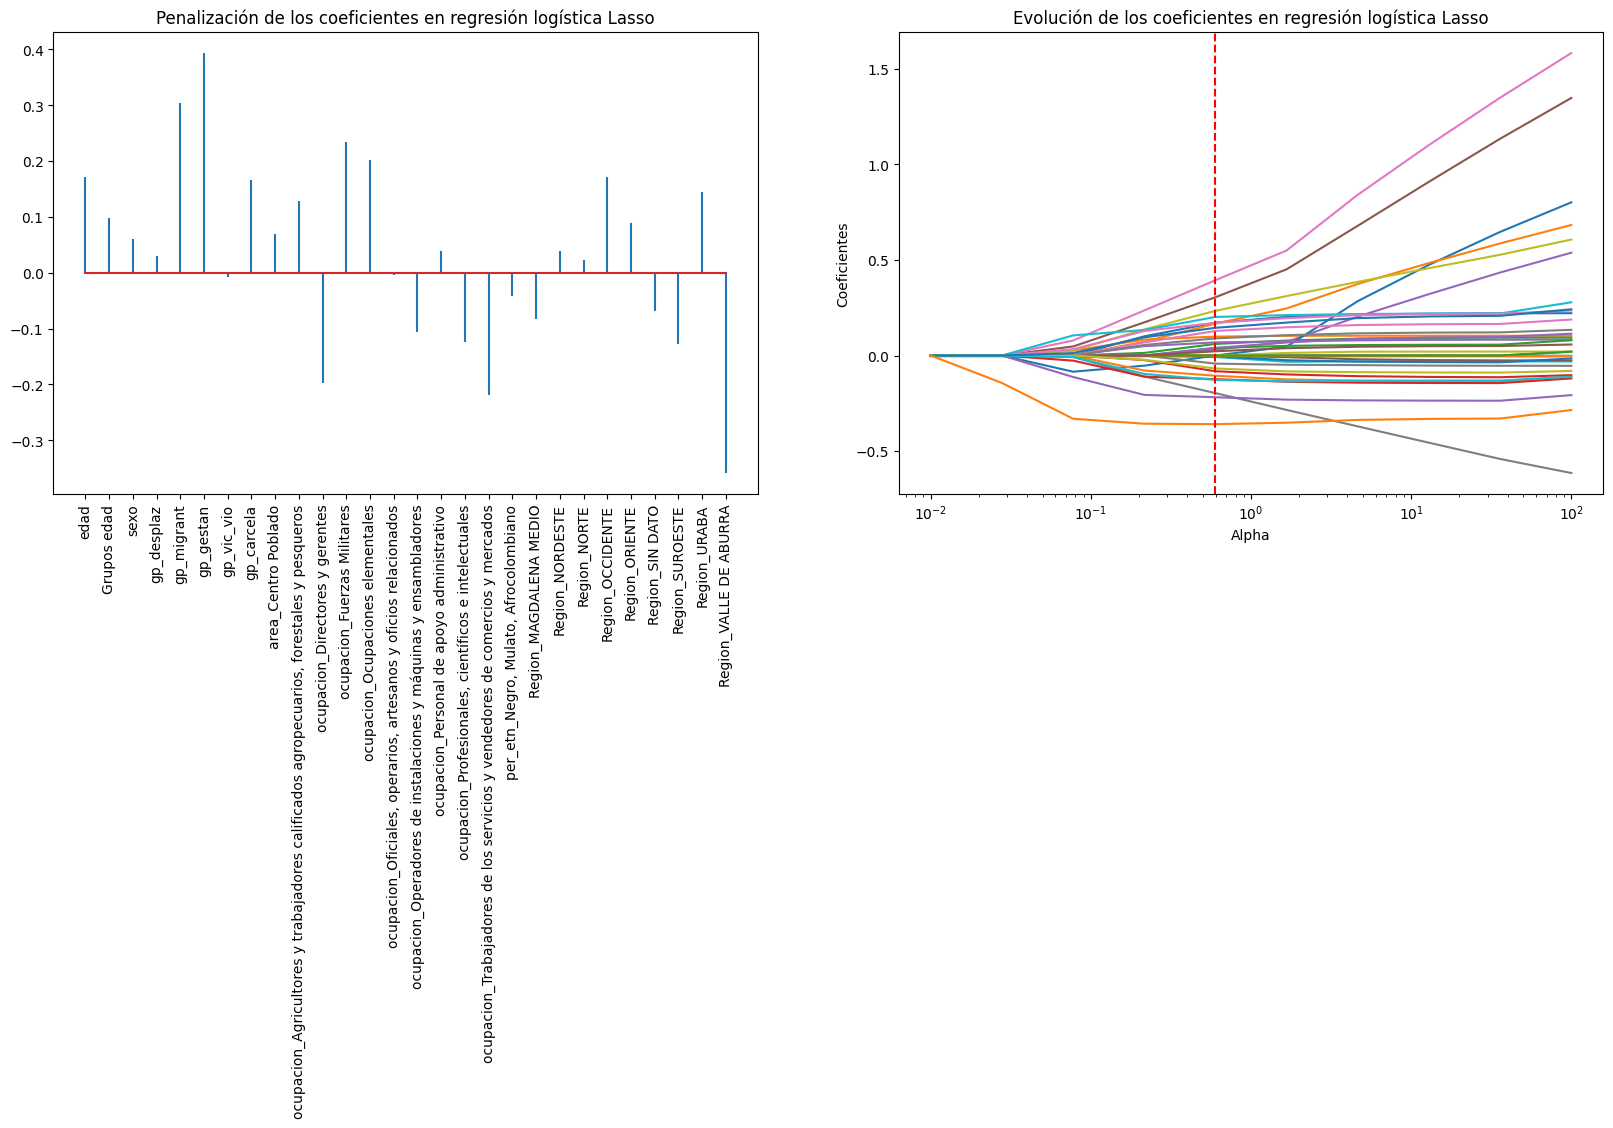

In [18]:
# Instanciar el Objeto RegresionLogistica Lasso
cs = np.logspace(-2, 2, 10)                            # Definir los valores de alpha, se ponen 10 valores por la limitacion computacional
rl1 = RegresionLogisticaLasso(Cs = cs)
rl1.fit_model(X_train_scaled, y_train)
y_pred_lasso = rl1.predict(X_test_scaled)
rl1.evaluate(y_test, y_pred_lasso)                     # Evaluar el modelo
rl1.plot_confusion_matrix(y_test, y_pred_lasso)        # Matriz de confusión
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)

# Obtener los coeficientes para cada valor de alpha
lasso_coefs = []
for a in cs:
    lasso = LogisticRegression(penalty='l1', C=a, solver='liblinear', random_state=42)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_.flatten())  # Aplanar los coeficientes y agregarlos a la lista

lasso_coefs = np.array(lasso_coefs)  # Convertir la lista en un arreglo de numpy bidimensional (100, n_coeficientes)

# Coeficientes del modelo Lasso con el alpha óptimo y los predictores seleccionados
df_coeficientes_Lasso = pd.DataFrame({
    "predictores": X_train.columns,
    "coeficientes": rl1.coefs().flatten()
    })

df_coeficientes_Lasso = df_coeficientes_Lasso.query("coeficientes != 0")
#print(df_coeficientes_Lasso)

# Generar las gráficas para la evolución de los coeficientes de regresión
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Gráfica para penalización de Coeficientes
axes[0].stem(df_coeficientes_Lasso.predictores, df_coeficientes_Lasso.coeficientes, markerfmt = ' ')
axes[0].set_xticks(df_coeficientes_Lasso.predictores)
axes[0].set_xticklabels(df_coeficientes_Lasso.predictores, rotation = 90)
axes[0].set_title('Penalización de los coeficientes en regresión logística Lasso')
# Gráfica para coeficientes vs Alpha
axes[1].plot(cs, lasso_coefs)
axes[1].axvline(rl1.model.C_, color='red', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coeficientes')
axes[1].set_title('Evolución de los coeficientes en regresión logística Lasso')
axes[1].axis('tight')

plt.tight_layout()
plt.show()

Los resultados muestran una exactitud (Accuracy) del 70%, pero un valor de Kappa de 0.00, lo que indica que el modelo no tiene mejor desempeño que una clasificación aleatoria. La precisión y el recall para la clase minoritaria (1) son extremadamente bajos, lo que sugiere que el modelo no está prediciendo correctamente los casos de la clase minoritaria. En resumen, aunque el modelo tiene una alta exactitud, su incapacidad para manejar el desbalance de clases lo hace inadecuado para este problema.

#### **Regresión Logística - Elastic Net**

Accuracy: 0.70
Kappa: 0.00
              precision    recall  f1-score   support

           0       1.00      0.70      0.82     48989
           1       0.00      0.59      0.00        54

    accuracy                           0.70     49043
   macro avg       0.50      0.65      0.41     49043
weighted avg       1.00      0.70      0.82     49043



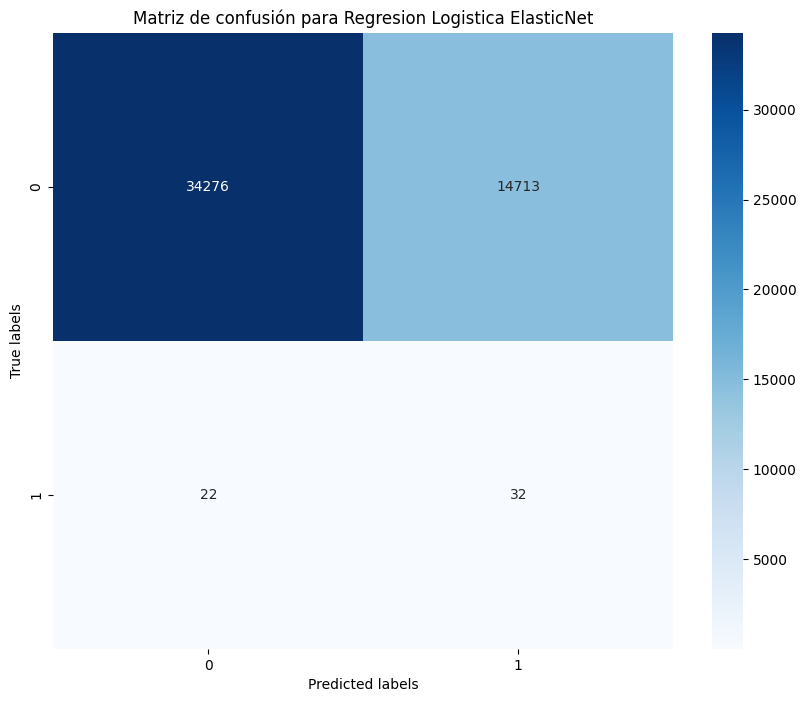

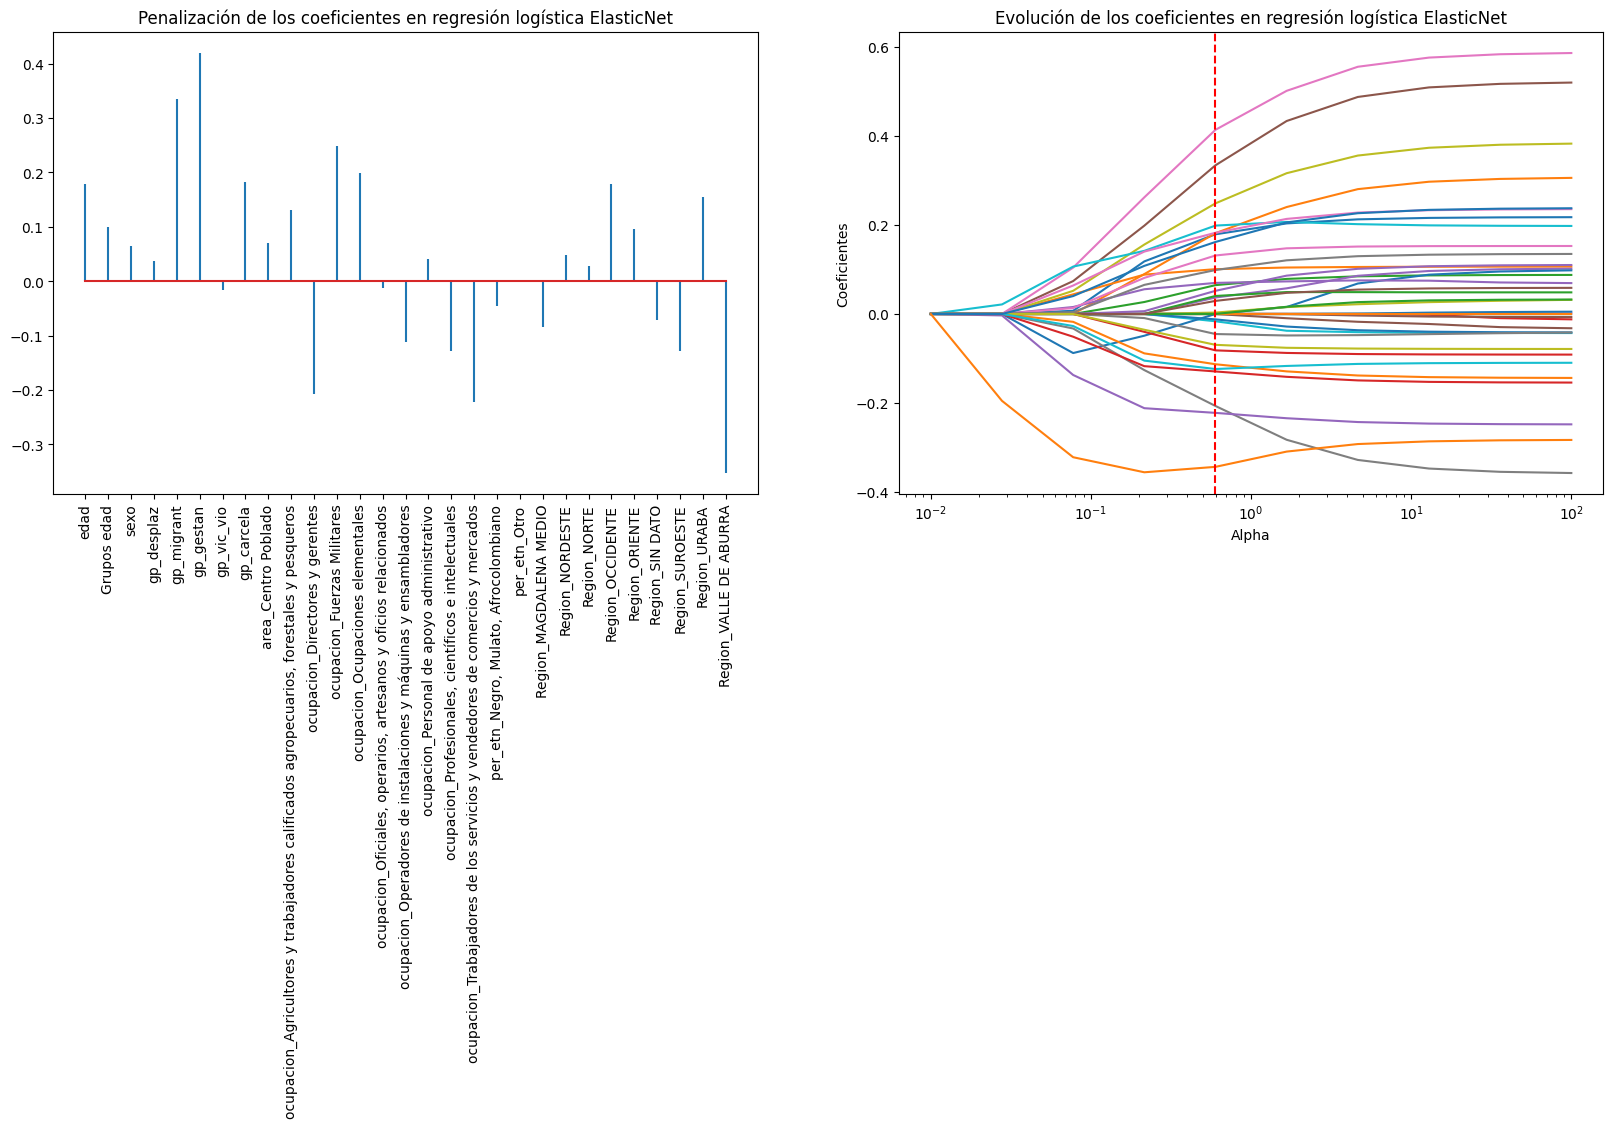

In [19]:
# Instanciar el Objeto RegresionLogistica ElasticNet

l1_ratios_vector=[0.2, 0.4, 0.6, 0.8, 1]                                # Definir los valores de l1, se ponen 5 valores por la limitacion computacional
cs = np.logspace(-2, 2, 10)                                             # Definir los valores de alpha, se ponen 10 valores por la limitacion computacional
rle = RegresionElasticNet(Cs = cs, l1_ratios=l1_ratios_vector)
rle.fit_model(X_train_scaled, y_train)
y_pred_enet = rle.predict(X_test_scaled)
rle.evaluate(y_test, y_pred_enet)                                      # Evaluar el modelo
rle.plot_confusion_matrix(y_test, y_pred_enet)                         # Matriz de confusión
accuracy_enet = accuracy_score(y_test, y_pred_enet)
# Obtener los coeficientes para cada valor de alpha con el l1_ratio óptimo
enet_coefs = []
for a in cs:
    enet = LogisticRegression(penalty='elasticnet', C=a, solver='saga', l1_ratio=rle.model.l1_ratio_[0], random_state=42)
    enet.fit(X_train_scaled, y_train)
    enet_coefs.append(enet.coef_.flatten())  # Aplanar los coeficientes y agregarlos a la lista

enet_coefs = np.array(enet_coefs)  # Convertir la lista en un arreglo de numpy bidimensional (100, n_coeficientes)

# Coeficientes del modelo Lasso con el alpha óptimo y los predictores seleccionados
df_coeficientes_Enet = pd.DataFrame({
    "predictores": X_train.columns,
    "coeficientes": rle.model.coef_.flatten()
    })

df_coeficientes_Enet = df_coeficientes_Enet.query("coeficientes != 0")
#print(df_coeficientes_Lasso)

# Generar las gráficas para la evolución de los coeficientes de regresión
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Gráfica para penalización de Coeficientes
axes[0].stem(df_coeficientes_Enet.predictores, df_coeficientes_Enet.coeficientes, markerfmt = ' ')
axes[0].set_xticks(df_coeficientes_Enet.predictores)
axes[0].set_xticklabels(df_coeficientes_Enet.predictores, rotation = 90)
axes[0].set_title('Penalización de los coeficientes en regresión logística ElasticNet')
# Gráfica para coeficientes vs Alpha
axes[1].plot(cs, enet_coefs)
axes[1].axvline(rle.model.C_, color='red', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coeficientes')
axes[1].set_title('Evolución de los coeficientes en regresión logística ElasticNet')
axes[1].axis('tight')

plt.tight_layout()
plt.show()

Al igual que los 3 modelos anteriores, aunque existe una alta exactitud, su incapacidad para manejar el desbalance de clases y predecir correctamente la clase minoritaria lo hace inadecuado para este problema.

### **Comparación de modelos**

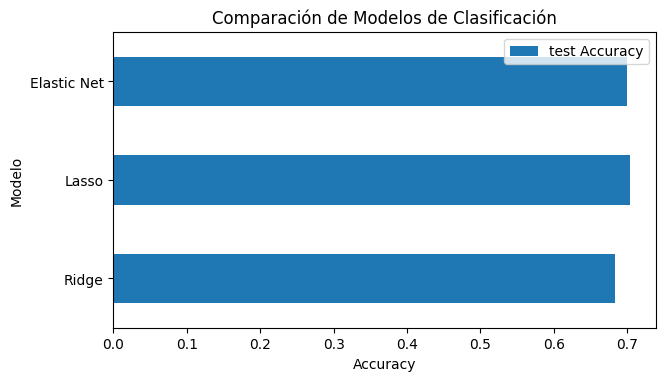

Accuracy para cada modelo:
        modelo  test Accuracy
0        Ridge       0.683258
1        Lasso       0.703974
2  Elastic Net       0.699549


In [20]:
# Comparación de modelos
df_comparacion = pd.DataFrame({
    'modelo': ['Ridge', 'Lasso', 'Elastic Net'],
    'test Accuracy': [accuracy_ridge, accuracy_lasso, accuracy_enet]
})

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Modelo')
ax.set_title('Comparación de Modelos de Clasificación')
plt.show()

# Mostrar Accuracy de cada modelo
print("Accuracy para cada modelo:")
print(df_comparacion)

### **Conclusión de resultados**

El modelo de **Regresión Logística con Lasso** ha mostrado el mejor rendimiento en términos de precisión para este conjunto de datos. 
Sin embargo, al ver la incapacidad de los 3 modelos para predecir correctamente la clase minoritaria, se puede concluir que ningún modelo no es lo suficientemente bueno para predecir la clase minoritaria.

### **Parte B - Predecir hospitalización de paciente a partir de Variables Clinicas**

#### **Depuración del Dataframe**
Inicialmente, se depuran las columnas de interés y se eliminan registros vacíos para el estudio 

In [21]:
df2 = df.copy() # Crear una copia del DataFrame original
df2['pac_hos'].value_counts()*100/df2.shape[0]

pac_hos
No    70.315693
Sí    29.684307
Name: count, dtype: float64

Como se observa anteriormente, la distribución de los 2 posibles valores en la columna objetivo es del 70% - 30%. No balancear los datos de df2 es decisión estratégica para mantener la integridad de los datos, evitar la introducción de sesgos y asegurar que el modelo sea capaz de manejar situaciones realistas y relevantes para el problema que estás tratando de resolver.

Se procede a depurar el dataframe de la parte 2 con las columnas de interés

In [22]:
df2 = df2[col_clinicas] # Eliminar columnas innecesarias
print(f'Registros del Dataframe Original: {df2.shape[0]}')

# Eliminar registros con datos nulos
df2.dropna(inplace=True)
print(f'Registros del Dataframe Eliminando nulos en columnas de interés: {df2.shape[0]}')

Registros del Dataframe Original: 50397
Registros del Dataframe Eliminando nulos en columnas de interés: 49640


#### **Dummificación de variables categoricas (binarias, ordinales y nominales)**

In [23]:
# Dumificación de variables categóricas (todas menos edad)
le = LabelEncoder()
for col in df2.columns[1:]:
    df2[col] = le.fit_transform(df2[col])

#### **Dataset de Prueba y de entrenamiento**

Se divide el dataset en 80-20 y se realiza la estandarizacion de los datos con un StandarScaler antes de generar los modelos

In [24]:
# Dividir el dataset en entrenamiento y prueba
X = df2.drop(columns=['pac_hos'])
y = df2['pac_hos']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Ajustar y transformar los datos de entrenamiento y prueba
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### **Regresión Logística**

Accuracy: 0.79
Kappa: 0.46
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      7026
           1       0.71      0.51      0.59      2902

    accuracy                           0.79      9928
   macro avg       0.76      0.71      0.73      9928
weighted avg       0.79      0.79      0.78      9928



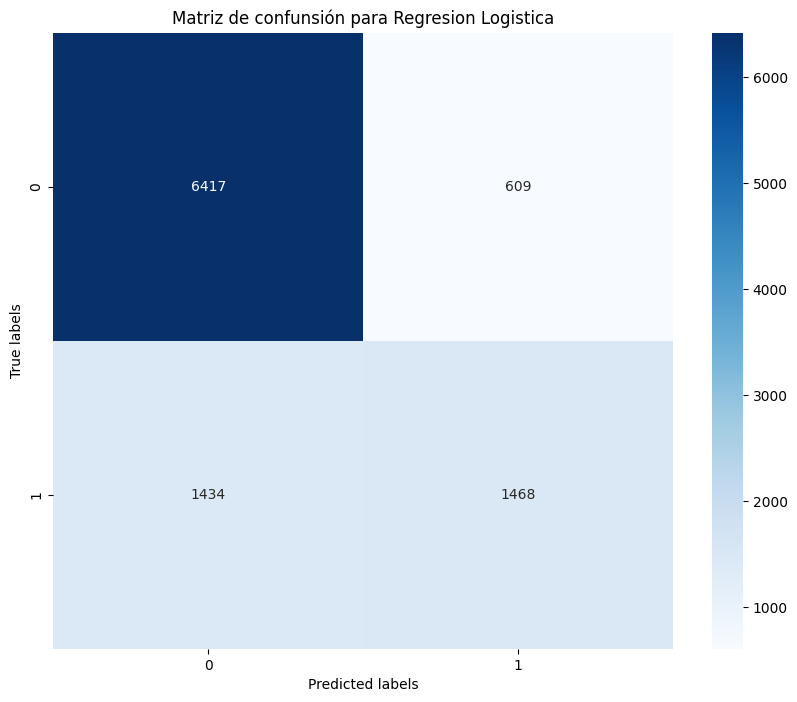

In [25]:
# Instanciar el Objeto RegresionLogistica
rl = RegresionLogistica()
rl.fit_model(X_train_scaled, y_train)
y_pred_rl = rl.predict(X_test_scaled)
rl.evaluate(y_test, y_pred_rl)                     # Evaluar el modelo
rl.plot_confusion_matrix(y_test, y_pred_rl)        # Matriz de confusión
accuracy_rl = accuracy_score(y_test, y_pred_rl)

- Exactitud (Accuracy): El modelo tiene una exactitud de 0.79 o 79%, lo cual es una mejora con respecto al baseline de 70%. Esto indica que el modelo es capaz de predecir correctamente en un 79% de los casos.
  
- Kappa: El valor de Kappa es de 0.46, lo cual sugiere una moderada concordancia entre las predicciones del modelo y los valores reales. Aunque está por encima de cero (lo cual indica que el modelo hace predicciones mejores que el azar), aún hay margen de mejora buscando un valor más cercano a 1.

**Metricas por Clase**
- **Para la clase 0:** La precisión es del 82%, el recall del 91%, y el F1-score del 86%. Esto muestra que el modelo es muy efectivo para predecir la clase 0.
- **Para la clase 1:** La precisión baja al 71%, el recall es aún más bajo con un 51%, y el F1-score es de 59%. Esto indica que el modelo tiene problemas para identificar correctamente los casos de la clase 1.

#### **Regresión Logística - Ridge**

Accuracy: 0.79
Kappa: 0.46
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      7026
           1       0.71      0.50      0.59      2902

    accuracy                           0.79      9928
   macro avg       0.76      0.71      0.73      9928
weighted avg       0.78      0.79      0.78      9928



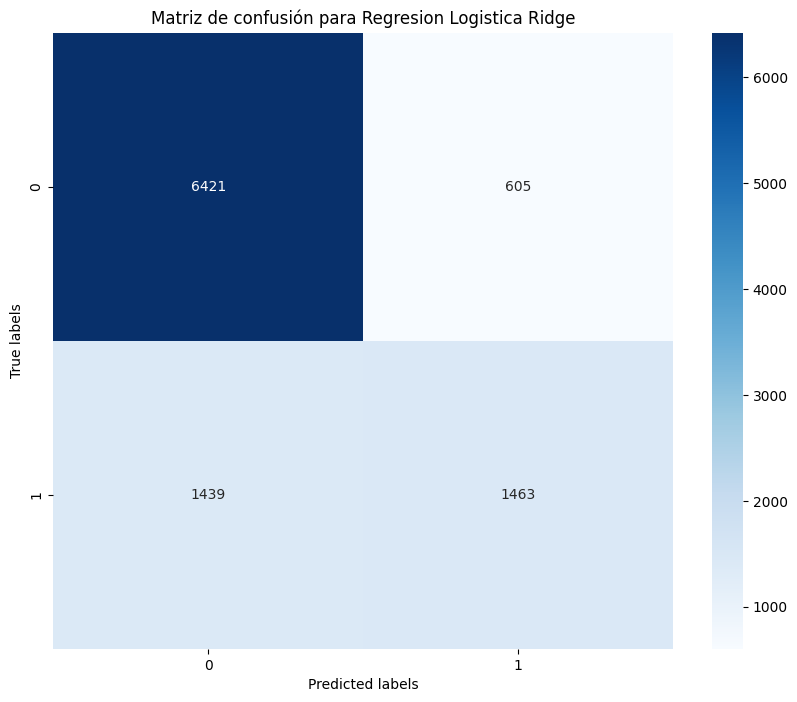

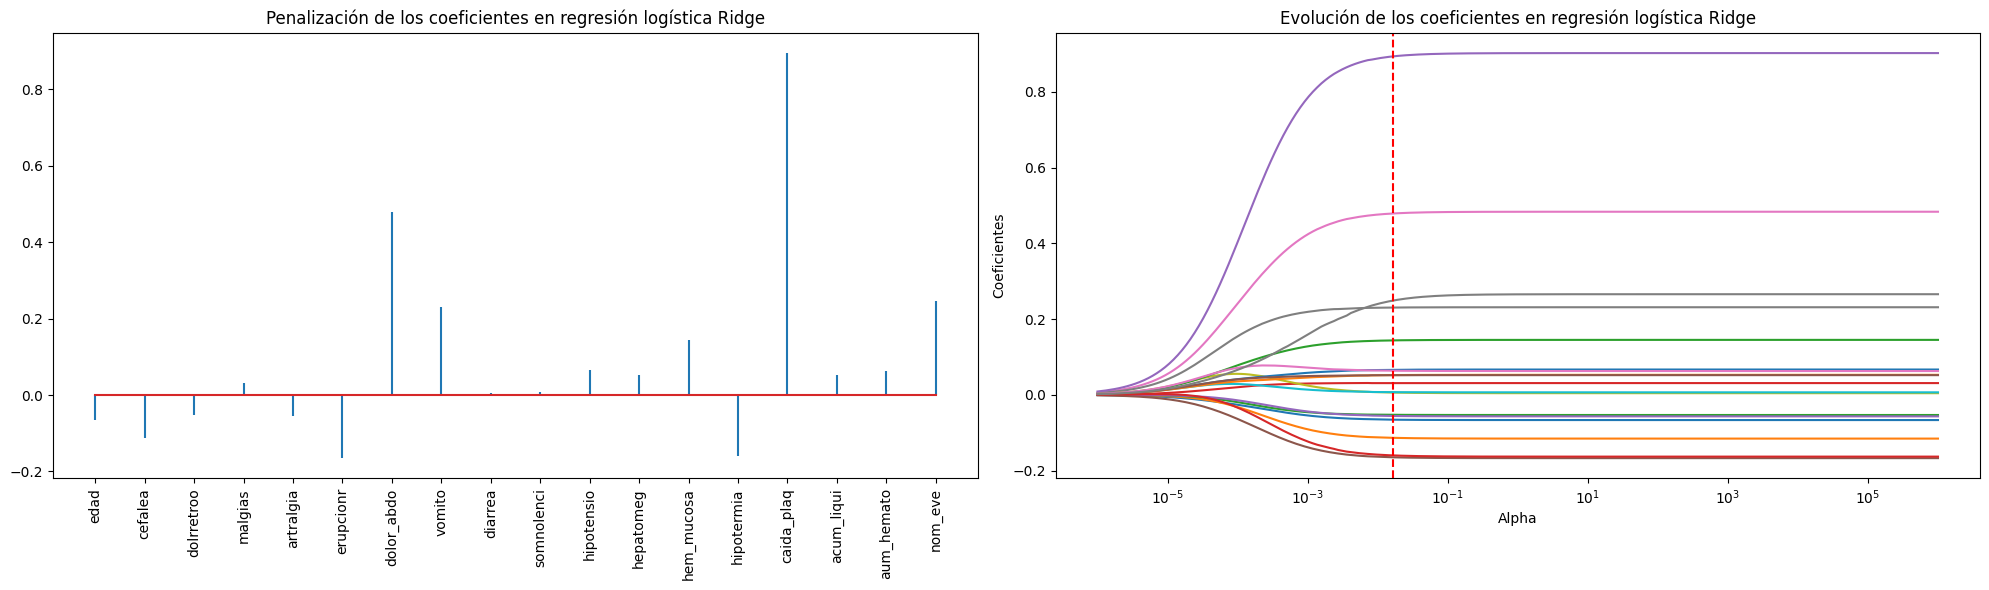

In [26]:
# Instanciar el Objeto RegresionLogistica Ridge
cs = np.logspace(-6, 6, 200)                            # Definir los valores de alpha
rl2 = RegresionLogisticaRidge(Cs = cs)
rl2.fit_model(X_train_scaled, y_train)
y_pred_ridge = rl2.predict(X_test_scaled)
rl2.evaluate(y_test, y_pred_ridge)                     # Evaluar el modelo
rl2.plot_confusion_matrix(y_test, y_pred_ridge)        # Matriz de confusión
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
# Obtener los coeficientes para cada valor de alpha
ridge_coefs = []
for a in cs:
    ridge = LogisticRegression(penalty='l2', C=a, solver='lbfgs', random_state=42)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_.flatten())  # Aplanar los coeficientes y agregarlos a la lista

ridge_coefs = np.array(ridge_coefs)  # Convertir la lista en un arreglo de numpy bidimensional (100, n_coeficientes)

# Coeficientes del modelo Ridge con el alpha óptimo y los predictores seleccionados
df_coeficientes_Ridge = pd.DataFrame({
    "predictores": X_train.columns,
    "coeficientes": rl2.coefs().flatten()
    })

df_coeficientes_Ridge = df_coeficientes_Ridge.query("coeficientes != 0")
#print(df_coeficientes_Ridge)

# Generar las gráficas para la evolución de los coeficientes de regresión
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Gráfica para penalización de Coeficientes
axes[0].stem(df_coeficientes_Ridge.predictores, df_coeficientes_Ridge.coeficientes, markerfmt = ' ')
axes[0].set_xticks(df_coeficientes_Ridge.predictores)
axes[0].set_xticklabels(df_coeficientes_Ridge.predictores, rotation = 90)
axes[0].set_title('Penalización de los coeficientes en regresión logística Ridge')
# Gráfica para coeficientes vs Alpha
axes[1].plot(cs, ridge_coefs)
axes[1].axvline(rl2.model.C_, color='red', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coeficientes')
axes[1].set_title('Evolución de los coeficientes en regresión logística Ridge')
axes[1].axis('tight')

plt.tight_layout()
plt.show()

- Exactitud (Accuracy): El modelo tiene una exactitud de 79%, lo cual es una mejora con respecto al baseline de 70%. Esto indica que el modelo es capaz de predecir correctamente en un 79% de los casos.
  
- Kappa: El valor de Kappa es de 0.46, lo cual sugiere una moderada concordancia entre las predicciones del modelo y los valores reales. Aunque está por encima de cero (lo cual indica que el modelo hace predicciones mejores que el azar), aún hay margen de mejora buscando un valor más cercano a 1.

**Metricas por Clase:**

- **Para la clase 0:** La precisión es del 82%, el recall del 91%, y el F1-score del 86%. Esto muestra que el modelo es muy efectivo para predecir la clase 0.
  
- **Para la clase 1:** La precisión baja al 71%, el recall es aún más bajo con un 50%, y el F1-score es de 59%. Esto indica que el modelo tiene problemas para identificar correctamente los casos de la clase 1.

Una vez aplicada la regresión Ridge, se observa que el modelo toma 18 variables, y aquellas con coeficientes más altos, como caida_plaq, dolor_abdo, vomito y nom_eve, tienen un peso importante en el modelo, lo que indica que estas características son relevantes para la predicción.

#### **Regresión Logística - Lasso**

Accuracy: 0.79
Kappa: 0.46
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      7026
           1       0.70      0.52      0.60      2902

    accuracy                           0.79      9928
   macro avg       0.76      0.71      0.73      9928
weighted avg       0.79      0.79      0.78      9928



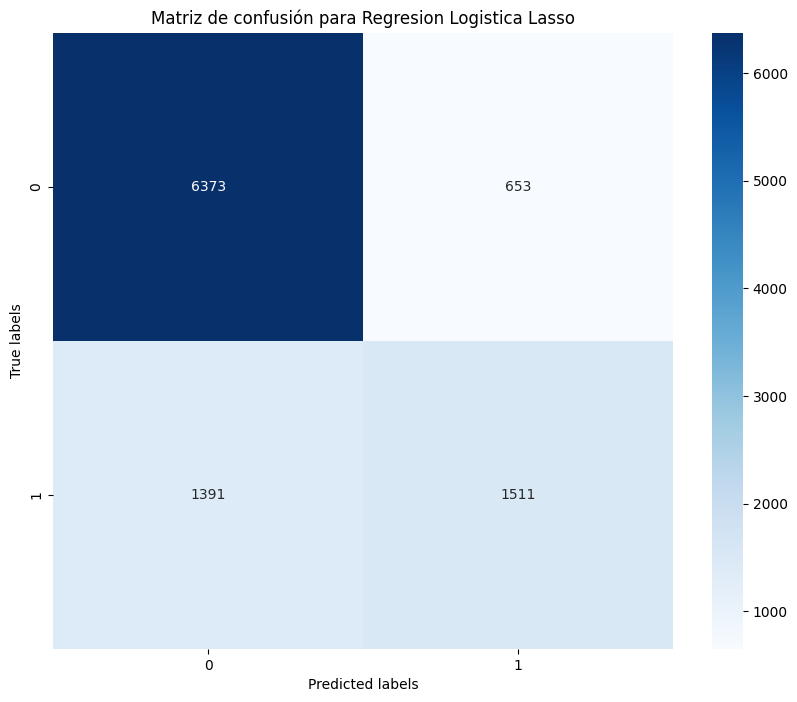

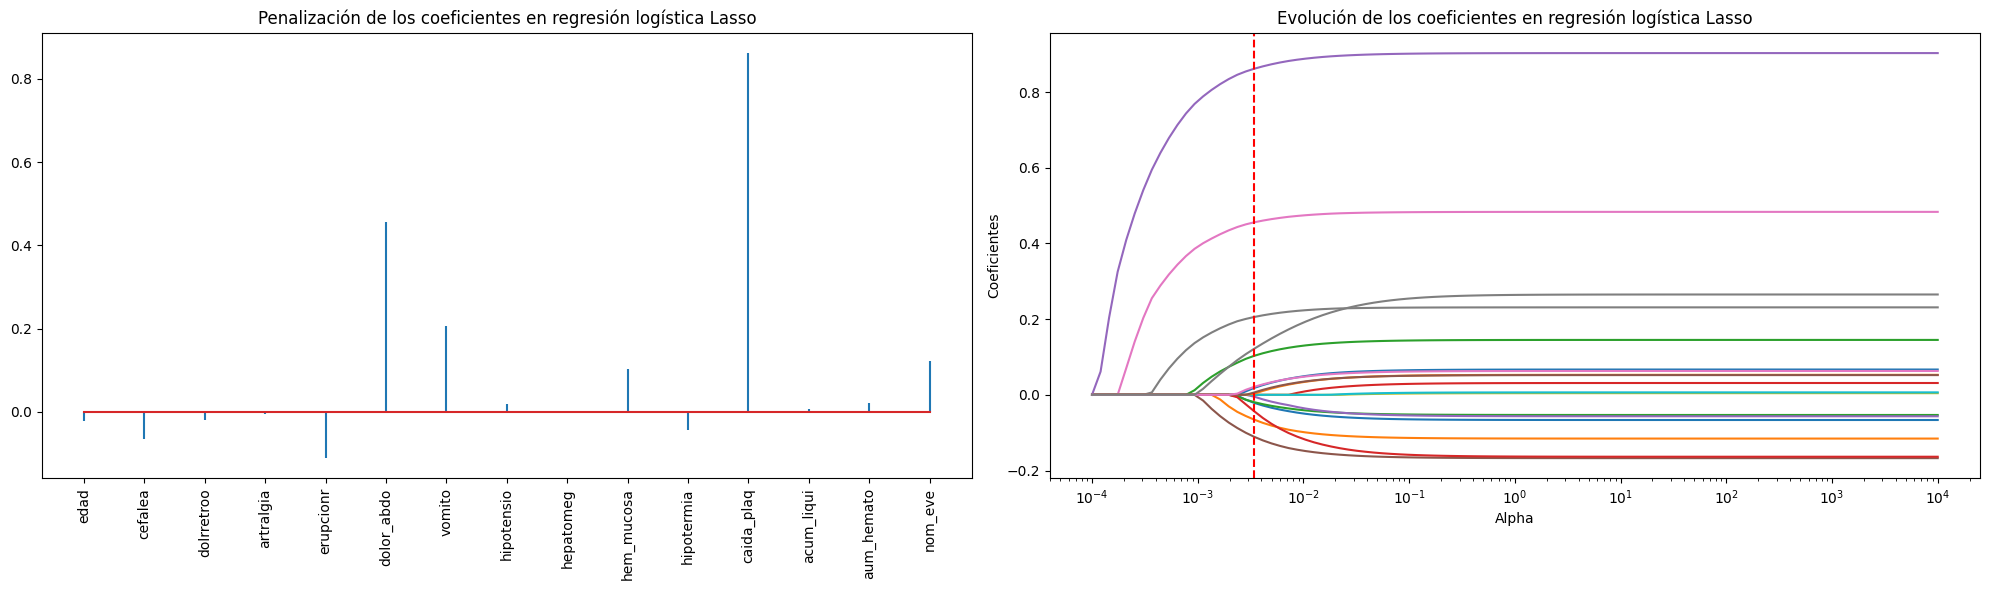

In [27]:
# Instanciar el Objeto RegresionLogistica Lasso
cs = np.logspace(-4, 4, 100)                            # Definir los valores de alpha, se ponen 10 valores por la limitacion computacional
rl1 = RegresionLogisticaLasso(Cs = cs)
rl1.fit_model(X_train_scaled, y_train)
y_pred_lasso = rl1.predict(X_test_scaled)
rl1.evaluate(y_test, y_pred_lasso)                     # Evaluar el modelo
rl1.plot_confusion_matrix(y_test, y_pred_lasso)        # Matriz de confusión
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)

# Obtener los coeficientes para cada valor de alpha
lasso_coefs = []
for a in cs:
    lasso = LogisticRegression(penalty='l1', C=a, solver='liblinear', random_state=42)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_.flatten())  # Aplanar los coeficientes y agregarlos a la lista

lasso_coefs = np.array(lasso_coefs)  # Convertir la lista en un arreglo de numpy bidimensional (100, n_coeficientes)

# Coeficientes del modelo Lasso con el alpha óptimo y los predictores seleccionados
df_coeficientes_Lasso = pd.DataFrame({
    "predictores": X_train.columns,
    "coeficientes": rl1.coefs().flatten()
    })

df_coeficientes_Lasso = df_coeficientes_Lasso.query("coeficientes != 0")
#print(df_coeficientes_Lasso)

# Generar las gráficas para la evolución de los coeficientes de regresión
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Gráfica para penalización de Coeficientes
axes[0].stem(df_coeficientes_Lasso.predictores, df_coeficientes_Lasso.coeficientes, markerfmt = ' ')
axes[0].set_xticks(df_coeficientes_Lasso.predictores)
axes[0].set_xticklabels(df_coeficientes_Lasso.predictores, rotation = 90)
axes[0].set_title('Penalización de los coeficientes en regresión logística Lasso')
# Gráfica para coeficientes vs Alpha
axes[1].plot(cs, lasso_coefs)
axes[1].axvline(rl1.model.C_, color='red', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coeficientes')
axes[1].set_title('Evolución de los coeficientes en regresión logística Lasso')
axes[1].axis('tight')

plt.tight_layout()
plt.show()

- Exactitud (Accuracy): El modelo tiene una exactitud de 79%, lo cual es una mejora con respecto al baseline de 70%. Esto indica que el modelo es capaz de predecir correctamente en un 79% de los casos.
  
- Kappa: El valor de Kappa es de 0.46, lo cual sugiere una moderada concordancia entre las predicciones del modelo y los valores reales. Aunque está por encima de cero (lo cual indica que el modelo hace predicciones mejores que el azar), aún hay margen de mejora buscando un valor más cercano a 1.

**Metricas por Clase:**

- **Para la clase 0:** La precisión es del 82%, el recall del 91%, y el F1-score del 86%. Esto muestra que el modelo es muy efectivo para predecir la clase 0.
  
- **Para la clase 1:** La precisión baja al 70%, el recall es aún más bajo con un 52%, y el F1-score es de 60%. Esto indica que el modelo tiene problemas para identificar correctamente los casos de la clase 1.

Una vez aplicada la regresión Lasso, se observa que el modelo toma 15 variables a diferencia de la Ridge y se observa que penaliza con mayor fuerza, y aquellas con coeficientes más altos, como caida_plaq, dolor_abdo, vomito y nom_eve, tienen un peso importante en el modelo, lo que indica que estas características son relevantes para la predicción.

#### **Regresión Logística - Elastic Net**

Accuracy: 0.79
Kappa: 0.46
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      7026
           1       0.70      0.52      0.60      2902

    accuracy                           0.79      9928
   macro avg       0.76      0.71      0.73      9928
weighted avg       0.79      0.79      0.78      9928



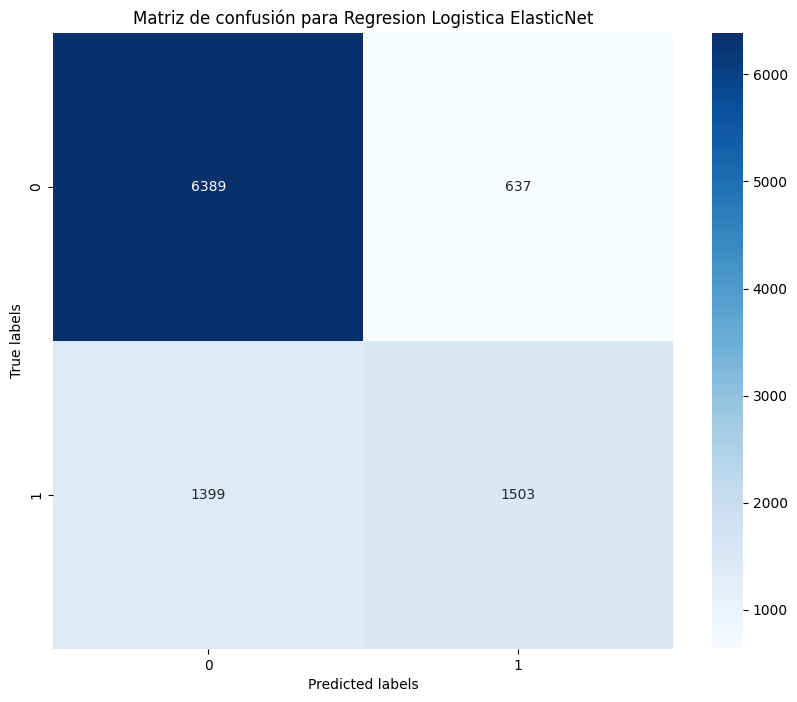

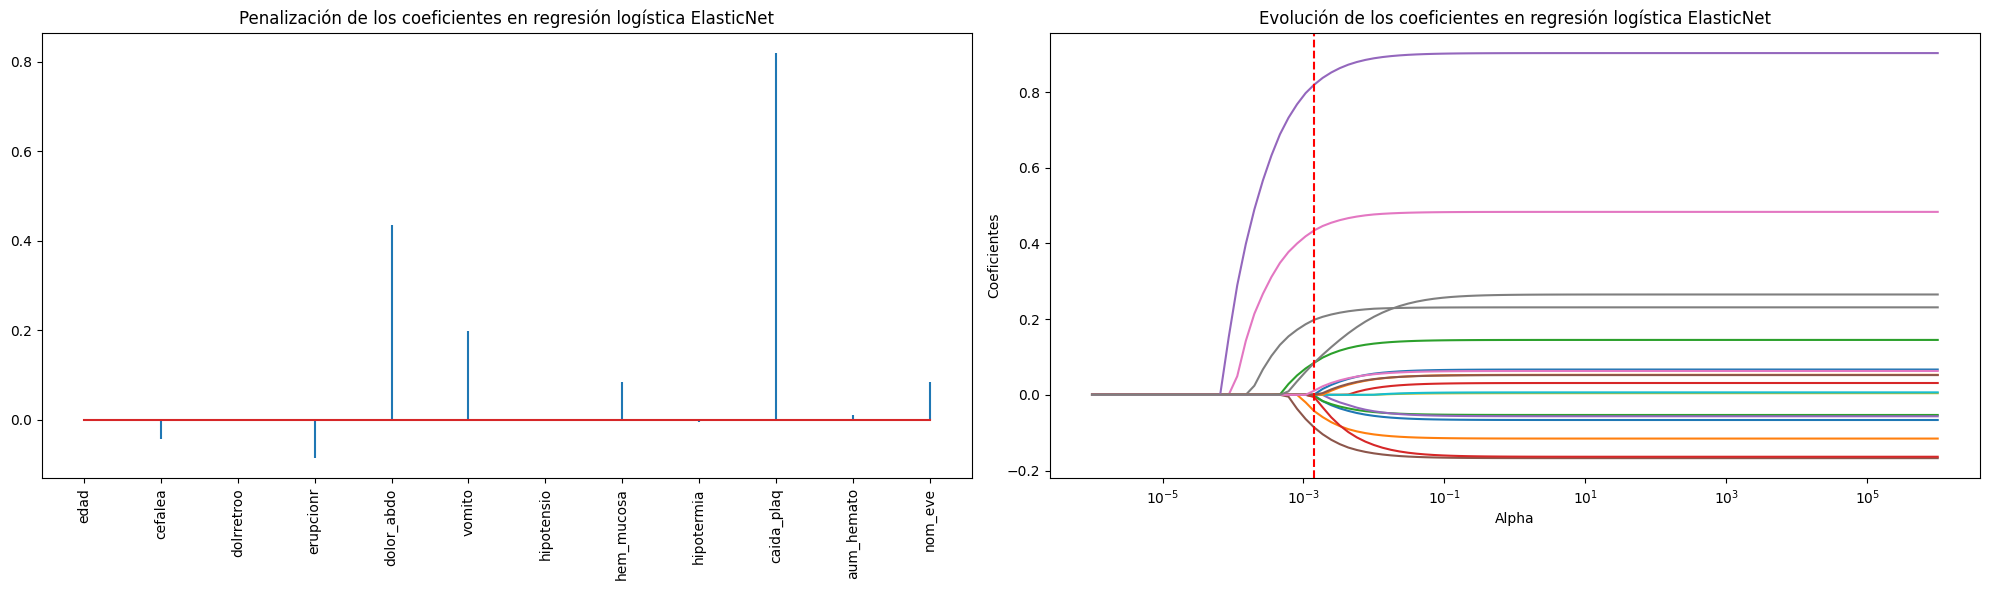

In [28]:
# Instanciar el Objeto RegresionLogistica ElasticNet

l1_ratios_vector=[0, 0.2, 0.4, 0.6, 0.8, 1]                              # Definir los valores de l1, se ponen 5 valores por la limitacion computacional
cs = np.logspace(-6, 6, 100)                                             # Definir los valores de alpha, se ponen 10 valores por la limitacion computacional
rle = RegresionElasticNet(Cs = cs, l1_ratios=l1_ratios_vector)
rle.fit_model(X_train_scaled, y_train)
y_pred_enet = rle.predict(X_test_scaled)
rle.evaluate(y_test, y_pred_enet)                                      # Evaluar el modelo
rle.plot_confusion_matrix(y_test, y_pred_enet)                         # Matriz de confusión
accuracy_enet = accuracy_score(y_test, y_pred_enet)

# Obtener los coeficientes para cada valor de alpha con el l1_ratio óptimo
enet_coefs = []
for a in cs:
    enet = LogisticRegression(penalty='elasticnet', C=a, solver='saga', l1_ratio=rle.model.l1_ratio_[0], random_state=42)
    enet.fit(X_train_scaled, y_train)
    enet_coefs.append(enet.coef_.flatten())  # Aplanar los coeficientes y agregarlos a la lista

enet_coefs = np.array(enet_coefs)  # Convertir la lista en un arreglo de numpy bidimensional (100, n_coeficientes)

# Coeficientes del modelo Lasso con el alpha óptimo y los predictores seleccionados
df_coeficientes_Enet = pd.DataFrame({
    "predictores": X_train.columns,
    "coeficientes": rle.model.coef_.flatten()
    })

df_coeficientes_Enet = df_coeficientes_Enet.query("coeficientes != 0")
#print(df_coeficientes_Lasso)

# Generar las gráficas para la evolución de los coeficientes de regresión
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Gráfica para penalización de Coeficientes
axes[0].stem(df_coeficientes_Enet.predictores, df_coeficientes_Enet.coeficientes, markerfmt = ' ')
axes[0].set_xticks(df_coeficientes_Enet.predictores)
axes[0].set_xticklabels(df_coeficientes_Enet.predictores, rotation = 90)
axes[0].set_title('Penalización de los coeficientes en regresión logística ElasticNet')
# Gráfica para coeficientes vs Alpha
axes[1].plot(cs, enet_coefs)
axes[1].axvline(rle.model.C_, color='red', linestyle='--')
axes[1].set_xscale('log')
axes[1].set_xlabel('Alpha')
axes[1].set_ylabel('Coeficientes')
axes[1].set_title('Evolución de los coeficientes en regresión logística ElasticNet')
axes[1].axis('tight')

plt.tight_layout()
plt.show()

- Exactitud (Accuracy): El modelo tiene una exactitud de 79%, lo cual es una mejora con respecto al baseline de 70%. Esto indica que el modelo es capaz de predecir correctamente en un 79% de los casos.
  
- Kappa: El valor de Kappa es de 0.46, lo cual sugiere una moderada concordancia entre las predicciones del modelo y los valores reales. Aunque está por encima de cero (lo cual indica que el modelo hace predicciones mejores que el azar), aún hay margen de mejora buscando un valor más cercano a 1.

**Metricas por Clase:**

- **Para la clase 0:** La precisión es del 82%, el recall del 91%, y el F1-score del 86%. Esto muestra que el modelo es muy efectivo para predecir la clase 0.
  
- **Para la clase 1:** La precisión baja al 70%, el recall es aún más bajo con un 52%, y el F1-score es de 60%. Esto indica que el modelo tiene problemas para identificar correctamente los casos de la clase 1.

Una vez aplicada la regresión ElasticNet, se observa que el modelo toma 12 variables a diferencia de la Ridge y Lasso. Ademas, por su comportamiento tiene una mayor parecido al Lasso en este caso particular y aquellas variables con coeficientes más altos, como caida_plaq, dolor_abdo, vomito y nom_eve, tienen un peso importante en el modelo, lo que indica que estas características son relevantes para la predicción.

### **Comparación de Modelos**

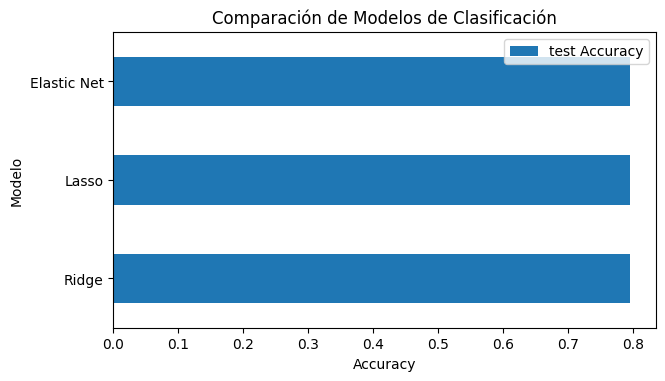

Accuracy para cada modelo:
        modelo  test Accuracy
0        Ridge       0.794118
1        Lasso       0.794118
2  Elastic Net       0.794923


In [29]:
# Comparación de modelos
df_comparacion = pd.DataFrame({
    'modelo': ['Ridge', 'Lasso', 'Elastic Net'],
    'test Accuracy': [accuracy_ridge, accuracy_lasso, accuracy_enet]
})

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Modelo')
ax.set_title('Comparación de Modelos de Clasificación')
plt.show()

# Mostrar Accuracy de cada modelo
print("Accuracy para cada modelo:")
print(df_comparacion)

**Conclusión final**

**Parte A del ejercicio:**
Al comparar los distintos modelos de regresión logística regularizada, se observa que todos ofrecen resultados muy similares en cuanto a exactitud, con el modelo Lasso una precisión de 70%, sin embargo, tener un Kappa de 0 en ambos tipos de dataframe (Balanceado y NO balanceado), indica que no se van a obtener mejores resultados que el Baseline para este tipo de problema de clasificación, en el cual de manera natural, una muy pequeña parte de la población tiene Dengue Grave. 

**Parte B del ejercicio:**
Al comparar los distintos modelos de regresión logística regularizada, se observa que todos ofrecen resultados muy similares en cuanto a exactitud, con el modelo Elastic Net logrando una precisión de 79.49%, apenas una ligera mejora frente a los otros modelos (79.41%). Sin embargo, Elastic Net es computacionalmente más exigente y su incremento en desempeño no es significativo.

Dado que se trata de un problema de clasificación donde la precisión es fundamental, especialmente en el contexto de la salud y la vida de los pacientes, se recomienda explorar modelos adicionales. Alternativas como árboles de decisión o métodos de ensamble como XGBoost podrían ofrecer un mejor desempeño, al ser capaces de captar relaciones no lineales y patrones complejos en los datos, lo que podría resultar en una mayor precisión y sensibilidad.